# Bitcoin Transaction Fee Estimation Pipeline

## Overview
This notebook implements the two-stage estimation pipeline for Bitcoin transaction fees, following the methodology in Section 5 of the paper "A Model and Estimation of the Bitcoin Transaction Fee."

**Goal**: Estimate the decomposition in Equation (5):
```
log(fee) = log(c_it) + log(W'(p_it, s_t)) + log(Weight) + const + ε
            ↑              ↑
        preferences    delay technology
```

## Pipeline Architecture
1. **Stage 1**: Delay Technology Estimation (Random Forest with monotonicity enforcement)
   - Cross-fitting via GroupKFold by epoch
   - Isotonic regression to enforce monotonicity in priority
   - Finite difference local slope computation

2. **Stage 2**: Hurdle Fee Model
   - **Extensive margin**: Logistic regression for P(fee > ε)
   - **Intensive margin**: Ridge regression on log-fee among fee-payers
   - Smearing correction for level predictions

**Key principle**: Priority → delay gradient → fee via impatience (VCG-consistent)

In [58]:
# =============================================================================
# Section 1: Imports and Configuration
# =============================================================================
import os
import gc
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
from dataclasses import dataclass, field
from typing import Optional, List, Tuple, Dict, Any
from scipy import stats
from scipy.interpolate import interp1d, BSpline
from scipy.optimize import minimize, lsq_linear

# Sklearn imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import SplineTransformer
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("Libraries imported successfully")
print(f"Pandas: {pd.__version__}, NumPy: {np.__version__}")

Libraries imported successfully
Pandas: 2.3.3, NumPy: 2.4.0


In [59]:
# =============================================================================
# Section 1.2: Configuration Dataclass
# =============================================================================
@dataclass
class EstimationConfig:
    """Configuration for the two-stage fee estimation pipeline."""
    
    # Database settings
    db_path: str = '/home/armin/datalake/data-samples/11-24-2025-15m-data-lake.db'
    block_limit: Optional[int] = 500  # None
    
    # Epoch parameters
    # epoch_mode: 'block', 'fixed_size', or 'time' (recommended for delay estimation)
    # Time-based epochs allow priority to predict delay (txs compete across multiple blocks)
    epoch_mode: str = 'time'  # Time-based is needed for priority→delay relationship
    blocks_per_epoch: int = 6  # Blocks per epoch (for epoch_mode='block')
    target_epoch_size: int = 1000  # Txs per epoch (for epoch_mode='fixed_size')
    epoch_duration_minutes: int = 30  # Minutes per epoch (for epoch_mode='time') - ~3 blocks
    
    # Stage 1 parameters (Delay Technology)
    n_folds: int = 5  # Cross-validation folds for cross-fitting
    rf_n_estimators: int = 200  # Trees in Random Forest
    rf_max_depth: int = 15  # Max tree depth
    rf_min_samples_leaf: int = 20  # Minimum samples per leaf
    
    # Slope computation parameters
    slope_delta: float = 0.05  # Δ for finite difference (Eq. 11)
    slope_trim: float = 0.01  # Boundary trimming for percentiles
    p_grid_size: int = 51  # Number of grid points for monotonization
    
    # Stage 2 parameters (Hurdle Model)
    fee_threshold_sat_vb: float = 2.1  # ε threshold for hurdle model (sat/vB)
    spline_n_knots: int = 4  # Interior knots for I-spline
    spline_degree: int = 3  # Cubic splines
    
    # Impatience proxy parameters
    respend_truncation_blocks: int = 144  # Max blocks for impatience calc (~1 day)
    epsilon: float = 1e-6  # Small constant for numerical stability
    
    # Max block weight (Bitcoin consensus)
    max_block_weight: int = 4_000_000
    
# Create default configuration
config = EstimationConfig()

print("Configuration created:")
print(f"  Database: {config.db_path}")
print(f"  Block limit: {config.block_limit}")
print(f"  Epoch mode: {config.epoch_mode}", end="")
if config.epoch_mode == 'block':
    print(f" ({config.blocks_per_epoch} block(s) per epoch)")
elif config.epoch_mode == 'fixed_size':
    print(f" (~{config.target_epoch_size} txs each)")
else:
    print(f" ({config.epoch_duration_minutes} min each)")
print(f"  Cross-fitting folds: {config.n_folds}")
print(f"  Finite difference delta: {config.slope_delta}")
print(f"  Fee threshold: {config.fee_threshold_sat_vb} sat/vB")

Configuration created:
  Database: /home/armin/datalake/data-samples/11-24-2025-15m-data-lake.db
  Block limit: 500
  Epoch mode: time (30 min each)
  Cross-fitting folds: 5
  Finite difference delta: 0.05
  Fee threshold: 2.1 sat/vB


---
## Section 2: Data Loading

In [60]:
# =============================================================================
# Section 2.1: Data Loading Functions (with corrected weights from mempool.space)
# =============================================================================

# Path to mempool.space corrected weight data
MEMPOOL_SPACE_DB = '/home/kristian/notebooks/mempool_space_data.db'


def get_valid_blocks_from_mempool_space() -> List[str]:
    """Get list of block hashes that have corrected weight data."""
    conn = sqlite3.connect(MEMPOOL_SPACE_DB)
    blocks = pd.read_sql_query(
        "SELECT DISTINCT block_hash FROM transactions", conn
    )['block_hash'].tolist()
    conn.close()
    return blocks


def load_corrected_weights() -> pd.DataFrame:
    """Load corrected weight/size/fee data from mempool.space database."""
    conn = sqlite3.connect(MEMPOOL_SPACE_DB)
    df = pd.read_sql_query("""
        SELECT 
            txid,
            weight as weight_corrected,
            size as size_corrected,
            vsize as vsize_corrected,
            fee as fee_corrected,
            fee_rate as fee_rate_corrected
        FROM transactions
    """, conn)
    conn.close()
    return df


def load_data_from_sqlite(db_path: str, block_limit: Optional[int] = None) -> pd.DataFrame:
    """
    Load transaction data from SQLite database.
    Only loads blocks that have corrected weight data from mempool.space.
    Merges corrected weight/size/fee values.
    
    Args:
        db_path: Path to SQLite database
        block_limit: Number of blocks to sample (None for all available)
        
    Returns:
        DataFrame with transaction data including corrected weights
    """
    print("=" * 60)
    print("Loading data from SQLite (with corrected weights)")
    print("=" * 60)
    
    # Get blocks that have corrected weight data
    valid_blocks = get_valid_blocks_from_mempool_space()
    print(f"Blocks with corrected weight data: {len(valid_blocks)}")
    
    conn = sqlite3.connect(db_path)
    
    # Get total count
    total_count = pd.read_sql_query(
        "SELECT COUNT(*) as count FROM mempool_transactions", conn
    )['count'].iloc[0]
    print(f"Total transactions in source database: {total_count:,}")
    
    # Filter to only valid blocks, with optional temporal balancing
    if block_limit and block_limit < len(valid_blocks):
        print(f"\nSampling {block_limit} blocks from {len(valid_blocks)} available...")
        
        # Get hour bins for temporal balancing
        placeholders = ','.join(['?' for _ in valid_blocks])
        all_blocks_query = f"""
            SELECT DISTINCT 
                conf_block_hash,
                strftime('%Y-%m-%d %H', mined_at) as hour_bin
            FROM mempool_transactions
            WHERE conf_block_hash IN ({placeholders})
              AND mined_at IS NOT NULL
        """
        all_blocks_df = pd.read_sql_query(all_blocks_query, conn, params=valid_blocks)
        print(f"Found {len(all_blocks_df):,} blocks with timestamps")
        
        # Temporally balanced sampling
        all_blocks_df = all_blocks_df.sample(frac=1, random_state=42)
        all_blocks_df['rank_in_hour'] = all_blocks_df.groupby('hour_bin').cumcount()
        
        n_hours = all_blocks_df['hour_bin'].nunique()
        blocks_per_hour = max(1, block_limit // n_hours)
        
        sampled_df = all_blocks_df[all_blocks_df['rank_in_hour'] < blocks_per_hour]
        
        if len(sampled_df) < block_limit:
            remaining = all_blocks_df[all_blocks_df['rank_in_hour'] >= blocks_per_hour]
            sampled_df = pd.concat([sampled_df, remaining.head(block_limit - len(sampled_df))])
        
        sampled_blocks = sampled_df['conf_block_hash'].head(block_limit).tolist()
        print(f"Sampled {len(sampled_blocks)} blocks with temporal balancing")
    else:
        sampled_blocks = valid_blocks
        print(f"Using all {len(sampled_blocks)} available blocks")
    
    # Load transactions from sampled blocks
    placeholders = ','.join(['?' for _ in sampled_blocks])
    query = f"""
        SELECT 
            tx_id,
            conf_block_hash,
            found_at,
            mined_at,
            fee_rate as fee_rate_original,
            waittime,
            weight as weight_original,
            size as size_original,
            min_respend_blocks,
            child_txid,
            rbf_fee_total,
            mempool_tx_count,
            mempool_size,
            total_output_amount,
            absolute_fee as absolute_fee_original
        FROM mempool_transactions 
        WHERE conf_block_hash IN ({placeholders})
    """
    
    print("Loading transactions from source database...")
    df = pd.read_sql_query(query, conn, params=sampled_blocks)
    conn.close()
    
    print(f"Loaded {len(df):,} transactions from source")
    
    # Load and merge corrected weights
    print("\nMerging corrected weight data from mempool.space...")
    corrected_df = load_corrected_weights()
    print(f"Corrected weight data available for {len(corrected_df):,} transactions")
    
    # Merge corrected data
    df = df.merge(
        corrected_df,
        left_on='tx_id',
        right_on='txid',
        how='left'
    )
    
    # Use corrected values where available, fall back to original
    df['weight'] = df['weight_corrected'].fillna(df['weight_original'])
    df['size'] = df['size_corrected'].fillna(df['size_original'])
    df['fee_rate'] = df['fee_rate_corrected'].fillna(df['fee_rate_original'])
    df['absolute_fee'] = df['fee_corrected'].fillna(df['absolute_fee_original'])
    
    # Compute vsize from weight (vsize = weight / 4, this is how fee_rate is calculated)
    # Use corrected vsize where available, otherwise compute from weight
    df['vsize'] = df['vsize_corrected'].fillna(df['weight'] / 4)
    
    # Track which rows have corrected data
    df['has_corrected_weight'] = df['weight_corrected'].notna()
    
    # Clean up merge columns
    df = df.drop(columns=['txid', 'weight_corrected', 'size_corrected', 
                          'vsize_corrected', 'fee_corrected', 'fee_rate_corrected'])
    
    # Summary
    corrected_count = df['has_corrected_weight'].sum()
    print(f"\n✓ Loaded {len(df):,} transactions")
    print(f"  - With corrected weights: {corrected_count:,} ({100*corrected_count/len(df):.1f}%)")
    print(f"  - Using original weights: {len(df) - corrected_count:,}")
    print(f"Columns: {list(df.columns)}")
    
    return df


def check_data_quality(df: pd.DataFrame) -> pd.DataFrame:
    """
    Check data quality and perform basic cleaning.
    
    Args:
        df: Raw transaction DataFrame
        
    Returns:
        Cleaned DataFrame
    """
    print("\n" + "=" * 60)
    print("Data Quality Check")
    print("=" * 60)
    
    # Check missing values
    print("\nMissing Values Summary:")
    missing = df.isnull().sum()
    print(missing[missing > 0])
    
    # Weight correction summary
    if 'has_corrected_weight' in df.columns:
        print("\n--- Weight Correction Summary ---")
        corrected = df['has_corrected_weight'].sum()
        print(f"Transactions with corrected weights: {corrected:,} ({100*corrected/len(df):.1f}%)")
        
        if 'weight_original' in df.columns:
            # Compare original vs corrected for those with corrections
            corrected_df = df[df['has_corrected_weight']].copy()
            if len(corrected_df) > 0:
                weight_diff = corrected_df['weight'] - corrected_df['weight_original']
                print(f"Mean weight correction: +{weight_diff.mean():.1f} WU ({100*weight_diff.mean()/corrected_df['weight_original'].mean():.1f}%)")
    
    # Basic statistics
    print(f"\nBasic Statistics (using corrected weights):")
    print(df[['fee_rate', 'waittime', 'weight', 'mempool_tx_count']].describe())
    
    # Remove rows with missing critical values
    critical_cols = ['fee_rate', 'waittime', 'weight', 'mempool_tx_count']
    df_clean = df.dropna(subset=critical_cols).copy()
    
    print(f"\n✓ Clean dataset: {len(df_clean):,} transactions ({len(df_clean)/len(df)*100:.1f}% retained)")
    
    return df_clean

In [61]:
# =============================================================================
# Section 2.2: Load Data
# =============================================================================
# Load data from database
df_raw = load_data_from_sqlite(config.db_path, config.block_limit)

# Check data quality and clean
df = check_data_quality(df_raw)

# Free memory
del df_raw
gc.collect()

print(f"\nDataset ready with {len(df):,} transactions")

Loading data from SQLite (with corrected weights)
Blocks with corrected weight data: 5965
Total transactions in source database: 14,984,540

Sampling 500 blocks from 5965 available...
Found 5,988 blocks with timestamps
Sampled 500 blocks with temporal balancing
Loading transactions from source database...
Loaded 1,290,196 transactions from source

Merging corrected weight data from mempool.space...
Corrected weight data available for 19,065,494 transactions

✓ Loaded 1,290,196 transactions
  - With corrected weights: 1,274,551 (98.8%)
  - Using original weights: 15,645
Columns: ['tx_id', 'conf_block_hash', 'found_at', 'mined_at', 'fee_rate_original', 'waittime', 'weight_original', 'size_original', 'min_respend_blocks', 'child_txid', 'rbf_fee_total', 'mempool_tx_count', 'mempool_size', 'total_output_amount', 'absolute_fee_original', 'weight', 'size', 'fee_rate', 'absolute_fee', 'vsize', 'has_corrected_weight']

Data Quality Check

Missing Values Summary:
child_txid           939186
rbf_

---
## Section 2.3: CPFP Package Collapsing

**Key insight**: Miners evaluate CPFP packages as a unit, not individual transactions. When a parent has 0 sat/vB and its child has 20 sat/vB, miners compute the combined (package) fee rate as:

```
package_fee_rate = (parent_fee + child_fee) / (parent_vsize + child_vsize)
```

We use `absolute_fee` and `size` (=vsize) columns for accurate calculation matching miner behavior.

This section:
1. Identifies CPFP parent-child pairs (parent has `child_txid`)
2. Fetches child transaction data from the database
3. Computes package fee rate for CPFP pairs
4. Collapses each pair into a single observation using package metrics
5. Removes child transactions (now part of the package observation)

In [62]:
# =============================================================================
# Section 2.3: CPFP Package Collapsing Functions
# =============================================================================

def fetch_child_transaction_data(db_path: str, child_txids: List[str]) -> pd.DataFrame:
    """
    Fetch fee and weight data for child transactions.
    Uses corrected data from mempool.space where available.
    
    Args:
        db_path: Path to SQLite database
        child_txids: List of child transaction IDs to fetch
        
    Returns:
        DataFrame with child transaction data including corrected weight/vsize/fee
    """
    if not child_txids:
        return pd.DataFrame(columns=['tx_id', 'fee_rate', 'weight', 'vsize', 'absolute_fee', 'size', 'waittime'])
    
    chunk_size = 900
    
    # First, get corrected data from mempool.space database
    corrected_conn = sqlite3.connect(MEMPOOL_SPACE_DB)
    corrected_list = []
    
    for i in range(0, len(child_txids), chunk_size):
        chunk = child_txids[i:i + chunk_size]
        placeholders = ','.join(['?' for _ in chunk])
        
        query = f"""
            SELECT 
                txid as tx_id,
                weight as weight_corrected,
                vsize as vsize_corrected,
                fee as fee_corrected,
                fee_rate as fee_rate_corrected,
                size as size_corrected
            FROM transactions 
            WHERE txid IN ({placeholders})
        """
        chunk_df = pd.read_sql_query(query, corrected_conn, params=chunk)
        corrected_list.append(chunk_df)
    
    corrected_conn.close()
    corrected_df = pd.concat(corrected_list, ignore_index=True) if corrected_list else pd.DataFrame()
    
    # Get original data from source database
    conn = sqlite3.connect(db_path)
    children_list = []
    
    for i in range(0, len(child_txids), chunk_size):
        chunk = child_txids[i:i + chunk_size]
        placeholders = ','.join(['?' for _ in chunk])
        
        query = f"""
            SELECT 
                tx_id,
                fee_rate as fee_rate_original,
                weight as weight_original,
                absolute_fee as absolute_fee_original,
                size as size_original,
                waittime
            FROM mempool_transactions 
            WHERE tx_id IN ({placeholders})
        """
        
        chunk_df = pd.read_sql_query(query, conn, params=chunk)
        children_list.append(chunk_df)
    
    conn.close()
    
    if not children_list:
        return pd.DataFrame(columns=['tx_id', 'fee_rate', 'weight', 'vsize', 'absolute_fee', 'size', 'waittime'])
    
    children_df = pd.concat(children_list, ignore_index=True)
    
    # Merge corrected data
    if len(corrected_df) > 0:
        children_df = children_df.merge(corrected_df, on='tx_id', how='left')
        
        # Use corrected values where available
        children_df['weight'] = children_df['weight_corrected'].fillna(children_df['weight_original'])
        children_df['size'] = children_df['size_corrected'].fillna(children_df['size_original'])
        children_df['fee_rate'] = children_df['fee_rate_corrected'].fillna(children_df['fee_rate_original'])
        children_df['absolute_fee'] = children_df['fee_corrected'].fillna(children_df['absolute_fee_original'])
        children_df['vsize'] = children_df['vsize_corrected'].fillna(children_df['weight'] / 4)
        
        # Clean up
        drop_cols = [c for c in children_df.columns if c.endswith('_corrected') or c.endswith('_original')]
        children_df = children_df.drop(columns=drop_cols, errors='ignore')
    else:
        # No corrected data - compute vsize from weight
        children_df['weight'] = children_df['weight_original']
        children_df['size'] = children_df['size_original']
        children_df['fee_rate'] = children_df['fee_rate_original']
        children_df['absolute_fee'] = children_df['absolute_fee_original']
        children_df['vsize'] = children_df['weight'] / 4
        drop_cols = [c for c in children_df.columns if c.endswith('_original')]
        children_df = children_df.drop(columns=drop_cols, errors='ignore')
    
    return children_df


def collapse_cpfp_packages(df: pd.DataFrame, db_path: str) -> pd.DataFrame:
    """
    Collapse CPFP parent-child pairs into single package observations.
    
    Miners evaluate CPFP packages as a unit. Package fee rate is computed
    as miners do - total fees divided by total virtual size:
    - package_fee_rate = (parent_fee + child_fee) / (parent_vsize + child_vsize)
    
    This function:
    1. Identifies parents (transactions with child_txid)
    2. Fetches child transaction data
    3. Computes package fee rate
    4. Updates parent rows with package metrics
    5. Removes child rows from the dataset
    
    Args:
        df: Transaction DataFrame with child_txid column
        db_path: Path to database for fetching child data
        
    Returns:
        DataFrame with CPFP pairs collapsed to single observations
    """
    print("=" * 60)
    print("CPFP PACKAGE COLLAPSING")
    print("=" * 60)
    
    # Identify CPFP parents
    cpfp_mask = df['child_txid'].notna() & (df['child_txid'] != '')
    n_parents = cpfp_mask.sum()
    
    print(f"\nCPFP Parents found: {n_parents:,} ({n_parents/len(df)*100:.2f}%)")
    
    if n_parents == 0:
        print("No CPFP transactions to collapse.")
        return df
    
    # Get unique child txids
    child_txids = df.loc[cpfp_mask, 'child_txid'].unique().tolist()
    print(f"Unique child transactions: {len(child_txids):,}")
    
    # Fetch child transaction data
    print("Fetching child transaction data from database...")
    children_df = fetch_child_transaction_data(db_path, child_txids)
    print(f"  Found {len(children_df):,} child transactions in database")
    
    if len(children_df) == 0:
        print("WARNING: No child transactions found in database. Skipping collapse.")
        return df
    
    # Calculate absolute_fee for parents if missing (fee_rate * weight / 4)
    if 'absolute_fee' not in df.columns or df['absolute_fee'].isna().any():
        df['absolute_fee'] = df['absolute_fee'].fillna(df['fee_rate'] * df['weight'] / 4)
    
    # Same for children
    if children_df['absolute_fee'].isna().any():
        children_df['absolute_fee'] = children_df['absolute_fee'].fillna(
            children_df['fee_rate'] * children_df['weight'] / 4
        )
    
    # Create lookup dict for child data (use vsize for fee_rate calculation)
    child_data = children_df.set_index('tx_id')[['fee_rate', 'weight', 'vsize', 'absolute_fee', 'size']].to_dict('index')
    
    # Statistics before collapse
    parent_fee_rates = df.loc[cpfp_mask, 'fee_rate']
    print(f"\nBefore collapse:")
    print(f"  Parent fee rates: mean={parent_fee_rates.mean():.2f}, median={parent_fee_rates.median():.2f}")
    print(f"  Zero-fee parents: {(parent_fee_rates == 0).sum():,}")
    
    # Calculate package metrics for each CPFP parent
    print("\nCalculating package fee rates using vsize...")
    
    package_fee_rates = []
    package_weights = []
    package_vsizes = []
    matched_count = 0
    unmatched_count = 0
    
    for idx in df[cpfp_mask].index:
        child_txid = df.loc[idx, 'child_txid']
        parent_fee = df.loc[idx, 'absolute_fee']
        parent_vsize = df.loc[idx, 'vsize']  # Use vsize for fee rate calculation
        parent_weight = df.loc[idx, 'weight']
        
        if child_txid in child_data:
            child_info = child_data[child_txid]
            child_fee = child_info['absolute_fee']
            child_vsize = child_info['vsize']  # Use vsize for fee rate calculation
            child_weight = child_info['weight']
            
            # Package fee rate = total_fee / total_vsize (what miners compute)
            total_fee = parent_fee + child_fee
            total_vsize = parent_vsize + child_vsize
            total_weight = parent_weight + child_weight
            package_fee_rate = total_fee / total_vsize  # sat/vB (correct formula)
            
            package_fee_rates.append(package_fee_rate)
            package_weights.append(total_weight)
            package_vsizes.append(total_vsize)
            matched_count += 1
        else:
            # Child not found - keep original values
            package_fee_rates.append(df.loc[idx, 'fee_rate'])
            package_weights.append(df.loc[idx, 'weight'])
            package_vsizes.append(df.loc[idx, 'vsize'])
            unmatched_count += 1
    
    print(f"  Matched parent-child pairs: {matched_count:,}")
    print(f"  Unmatched (child not in DB): {unmatched_count:,}")
    
    # Store original values for reference
    df.loc[cpfp_mask, 'original_fee_rate'] = df.loc[cpfp_mask, 'fee_rate']
    df.loc[cpfp_mask, 'original_weight'] = df.loc[cpfp_mask, 'weight']
    df.loc[cpfp_mask, 'original_vsize'] = df.loc[cpfp_mask, 'vsize']
    
    # Update parent rows with package metrics
    df.loc[cpfp_mask, 'fee_rate'] = package_fee_rates
    df.loc[cpfp_mask, 'weight'] = package_weights
    df.loc[cpfp_mask, 'vsize'] = package_vsizes
    df.loc[cpfp_mask, 'is_cpfp_package'] = 1
    
    # Mark non-CPFP transactions
    df.loc[~cpfp_mask, 'is_cpfp_package'] = 0
    
    # Statistics after package calculation
    new_fee_rates = df.loc[cpfp_mask, 'fee_rate']
    print(f"\nAfter package calculation:")
    print(f"  Package fee rates: mean={new_fee_rates.mean():.2f}, median={new_fee_rates.median():.2f}")
    print(f"  Zero-fee packages: {(new_fee_rates == 0).sum():,}")
    
    # Find and remove child transactions from the dataset
    # These are now part of their parent's package observation
    print("\nRemoving child transactions from dataset...")
    child_txid_set = set(child_txids)
    is_child = df['tx_id'].isin(child_txid_set)
    n_children_in_data = is_child.sum()
    print(f"  Children found in dataset: {n_children_in_data:,}")
    
    # Remove children
    df_collapsed = df[~is_child].copy()
    
    print(f"\n" + "=" * 60)
    print("CPFP COLLAPSE SUMMARY")
    print("=" * 60)
    print(f"  Original transactions: {len(df):,}")
    print(f"  CPFP packages created: {matched_count:,}")
    print(f"  Children removed: {n_children_in_data:,}")
    print(f"  Final transactions: {len(df_collapsed):,}")
    print(f"  Reduction: {len(df) - len(df_collapsed):,} ({(len(df) - len(df_collapsed))/len(df)*100:.2f}%)")
    
    return df_collapsed

In [63]:
# Diagnostic: Check if fee_rate == absolute_fee / vsize
print("=" * 60)
print("DIAGNOSTIC: fee_rate vs absolute_fee/vsize")
print("=" * 60)

# Compute fee rate from absolute_fee and size
mask = (df['absolute_fee'].notna()) & (df['vsize'].notna()) & (df['vsize'] > 0)
df_check = df[mask].copy()
df_check['computed_rate'] = df_check['absolute_fee'] / (df_check['vsize'])
df_check['diff'] = df_check['fee_rate'] - df_check['computed_rate']

print(f"\nSample size: {len(df_check):,}")
print(f"\nDifference (fee_rate - absolute_fee/weight):")
print(f"  Mean: {df_check['diff'].mean():.6f}")
print(f"  Median: {df_check['diff'].median():.6f}")
print(f"  Std: {df_check['diff'].std():.6f}")
print(f"  Max abs: {df_check['diff'].abs().max():.6f}")

exact_match = (df_check['diff'].abs() < 0.0001).sum()
close_match = (df_check['diff'].abs() < 0.01).sum()
print(f"\nExact matches (diff < 0.0001): {exact_match:,} / {len(df_check):,} ({100*exact_match/len(df_check):.1f}%)")
print(f"Close matches (diff < 0.01): {close_match:,} / {len(df_check):,} ({100*close_match/len(df_check):.1f}%)")

print("\nSample comparison:")
print(df_check[['tx_id', 'fee_rate', 'absolute_fee', 'size', 'computed_rate', 'diff']].head(100).to_string())

DIAGNOSTIC: fee_rate vs absolute_fee/vsize

Sample size: 1,288,731

Difference (fee_rate - absolute_fee/weight):
  Mean: -0.008847
  Median: 0.000000
  Std: 0.597050
  Max abs: 659.776596

Exact matches (diff < 0.0001): 1,273,187 / 1,288,731 (98.8%)
Close matches (diff < 0.01): 1,273,385 / 1,288,731 (98.8%)

Sample comparison:
                                                               tx_id  fee_rate  absolute_fee       size  computed_rate    diff
0   f3a89e6410a273ab6d1b70c0cb8ba3698f5faa5bef6db807485a1a4a8d7b40be    1.5058      259.0000   407.0000         1.5058  0.0000
1   71a4034213dd03936d00e487ee096309fe74913f646990691a98153466d02587    2.3000      322.0000   223.0000         2.3000  0.0000
2   7126382aaf2efd5d244e6cbf3cd32c15d64409be99f504f56a70b9322b3bfe30   18.3486     2000.0000   191.0000        18.3486  0.0000
3   dd8fc1e3baabf1492e7eaee9020c0295c669d1b800450e38b708f662aa1500fb   13.6257     2330.0000   253.0000        13.6257  0.0000
4   9f3a5e31b8642f7910180c2722b3a5c0

In [64]:
# =============================================================================
# Section 2.4: Execute CPFP Collapse
# =============================================================================
# Collapse CPFP parent-child pairs into single package observations
# This reflects how miners actually evaluate transactions

df = collapse_cpfp_packages(df, config.db_path)

# Verify the collapse
print(f"\nDataset after CPFP collapse: {len(df):,} transactions")
print(f"  CPFP packages: {df['is_cpfp_package'].sum():,}")
print(f"  Non-CPFP transactions: {(df['is_cpfp_package'] == 0).sum():,}")

CPFP PACKAGE COLLAPSING

CPFP Parents found: 350,933 (27.23%)
Unique child transactions: 336,715
Fetching child transaction data from database...
  Found 333,024 child transactions in database

Before collapse:
  Parent fee rates: mean=1.68, median=1.00
  Zero-fee parents: 3,138

Calculating package fee rates using vsize...
  Matched parent-child pairs: 347,221
  Unmatched (child not in DB): 3,712

After package calculation:
  Package fee rates: mean=1.92, median=1.00
  Zero-fee packages: 42

Removing child transactions from dataset...
  Children found in dataset: 321,813

CPFP COLLAPSE SUMMARY
  Original transactions: 1,288,731
  CPFP packages created: 347,221
  Children removed: 321,813
  Final transactions: 966,918
  Reduction: 321,813 (24.97%)

Dataset after CPFP collapse: 966,918 transactions
  CPFP packages: 114,262.0
  Non-CPFP transactions: 852,656


---
## Section 3: Feature Engineering

This section prepares the features required for the two-stage model:
- Epoch assignment (30-minute windows)
- Tie-aware fee-rate percentiles (Eq. 8) - now using package fee rate for CPFP pairs
- Impatience proxy (ι = 1/min_respend_blocks)
- Blockspace utilization
- RBF indicator and CPFP package flag

In [65]:
# =============================================================================
# Section 3.1: Epoch Assignment
# =============================================================================

def assign_epochs(df: pd.DataFrame, epoch_mode: str = 'block', 
                  blocks_per_epoch: int = 3, target_epoch_size: int = 1000,
                  epoch_duration_minutes: int = 30) -> pd.DataFrame:
    """
    Assign transactions to epochs for cross-fitting and percentile computation.
    
    Three modes:
    
    1. 'block' (recommended): Each epoch = blocks_per_epoch consecutive blocks.
       Most economically aligned - priority is about competing for block space.
       Percentile computed among transactions that landed in the same block(s).
       
    2. 'fixed_size': Each epoch has ~target_epoch_size transactions.
       Ensures consistent epoch sizes with any sampling strategy.
       
    3. 'time': Traditional time-based windows (epoch_duration_minutes).
       Only works well with complete temporal coverage.
    
    Args:
        df: Transaction DataFrame
        epoch_mode: 'block', 'fixed_size', or 'time'
        blocks_per_epoch: Blocks per epoch (only for epoch_mode='block')
        target_epoch_size: Target txs per epoch (only for epoch_mode='fixed_size')
        epoch_duration_minutes: Minutes per epoch (only for epoch_mode='time')
        
    Returns:
        DataFrame with epoch_id column
    """
    print("Assigning epochs...")
    
    # Convert datetime columns
    df['found_at'] = pd.to_datetime(df['found_at'])
    df['mined_at'] = pd.to_datetime(df['mined_at'])
    
    if epoch_mode == 'block':
        # BLOCK-BASED EPOCHS: Most economically aligned
        # Priority is about competing for the next block
        print(f"  Mode: Block-based epochs ({blocks_per_epoch} block(s) per epoch)")
        
        # Get unique blocks sorted by mining time
        block_times = df.groupby('conf_block_hash')['mined_at'].min().sort_values()
        unique_blocks = block_times.index.tolist()
        n_blocks = len(unique_blocks)
        
        # Assign block sequence numbers
        block_to_seq = {block: i for i, block in enumerate(unique_blocks)}
        df['block_seq'] = df['conf_block_hash'].map(block_to_seq)
        
        # Group blocks into epochs
        df['epoch_id'] = df['block_seq'] // blocks_per_epoch
        
        n_epochs = df['epoch_id'].nunique()
        print(f"✓ Created {n_epochs} block-based epochs from {n_blocks} blocks")
        
    elif epoch_mode == 'fixed_size':
        # FIXED-SIZE EPOCHS: Consistent sizes regardless of sampling
        print(f"  Mode: Fixed-size epochs (~{target_epoch_size} txs each)")
        
        # Sort by found_at time
        df = df.sort_values('found_at').copy()
        
        # Assign epoch IDs based on position
        n_transactions = len(df)
        n_epochs = max(1, n_transactions // target_epoch_size)
        
        df['epoch_id'] = np.arange(n_transactions) // target_epoch_size
        df['epoch_id'] = df['epoch_id'].clip(upper=n_epochs - 1)
        
        print(f"✓ Created {df['epoch_id'].nunique()} fixed-size epochs")
        
    elif epoch_mode == 'time':
        # TIME-BASED EPOCHS: Traditional approach
        print(f"  Mode: Time-based epochs ({epoch_duration_minutes} min each)")
        
        df['found_at_ts'] = df['found_at'].astype('int64') // 10**9
        
        start_time = df['found_at_ts'].min()
        end_time = df['found_at_ts'].max()
        epoch_seconds = epoch_duration_minutes * 60
        num_epochs = int(np.ceil((end_time - start_time) / epoch_seconds)) + 1
        
        bins = np.linspace(start_time, start_time + (num_epochs * epoch_seconds), num_epochs + 1)
        df['epoch_id'] = pd.cut(df['found_at_ts'], bins=bins, labels=False, include_lowest=True)
        
        print(f"✓ Created {df['epoch_id'].nunique()} time-based epochs")
    else:
        raise ValueError(f"Unknown epoch_mode: {epoch_mode}. Use 'block', 'fixed_size', or 'time'.")
    
    # Epoch statistics
    epoch_counts = df.groupby('epoch_id').size()
    n_epochs = df['epoch_id'].nunique()
    
    print(f"\n  Epoch Statistics:")
    print(f"    Total epochs: {n_epochs}")
    print(f"    Transactions per Epoch:")
    print(f"      Min:    {epoch_counts.min():,.0f}")
    print(f"      25%:    {epoch_counts.quantile(0.25):,.0f}")
    print(f"      Median: {epoch_counts.median():,.0f}")
    print(f"      Mean:   {epoch_counts.mean():,.0f}")
    print(f"      75%:    {epoch_counts.quantile(0.75):,.0f}")
    print(f"      Max:    {epoch_counts.max():,.0f}")
    
    # Check for sparse epochs
    sparse_threshold = 50
    sparse_epochs = (epoch_counts < sparse_threshold).sum()
    if sparse_epochs > 0:
        print(f"    ⚠ Sparse epochs (<{sparse_threshold} txs): {sparse_epochs} ({100*sparse_epochs/n_epochs:.1f}%)")
    else:
        print(f"    ✓ No sparse epochs (all have >= {sparse_threshold} txs)")
    
    # Filter out epochs with less than 50 transactions
    df = df[df['epoch_id'].isin(epoch_counts[epoch_counts >= 50].index)]

    # Block-specific stats
    if epoch_mode == 'block':
        blocks_per = df.groupby('epoch_id')['conf_block_hash'].nunique()
        print(f"\n  Blocks per Epoch:")
        print(f"    Min:    {blocks_per.min():.0f}")
        print(f"    Median: {blocks_per.median():.0f}")
        print(f"    Max:    {blocks_per.max():.0f}")
    
    return df


def compute_fee_rate_percentile(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute tie-aware fee-rate percentile within each epoch (Eq. 8).
    
    Formula: p_it = (#{j: r_jt < r_it} + 0.5 * #{j: r_jt = r_it}) / N_t
    
    This defines priority where higher p_it = higher priority (higher fee rate).
    Uses midrank method for ties, staying strictly inside (0, 1).
    
    Args:
        df: Transaction DataFrame with epoch_id
        
    Returns:
        DataFrame with fee_rate_percentile column (higher = higher priority)
    """
    print("Computing tie-aware fee-rate percentiles...")
    
    def tie_aware_percentile(group):
        """
        Compute percentile using exact VCG formula.
        
        p_it = (#{j: r_j < r_it} + 0.5 * #{j: r_j = r_it}) / N
        
        Higher fee_rate → higher percentile → higher priority
        """
        r = group['fee_rate'].to_numpy()
        N = len(group)
        
        if N == 0:
            return pd.Series(dtype=float)
        if N == 1:
            return pd.Series([0.5], index=group.index)
        
        # Count occurrences of each unique fee rate
        vc = pd.Series(r).value_counts().sort_index()
        
        # Cumulative count of values strictly less than each value
        cum_less = vc.cumsum().shift(1, fill_value=0)
        
        # Map each fee rate to its "strictly less than" count
        less = pd.Series(r).map(cum_less).to_numpy()
        
        # Map each fee rate to its count (ties including self)
        eq = pd.Series(r).map(vc).to_numpy()
        
        # Compute percentile: (less + 0.5 * eq) / N
        # Higher fee rate → more values less than it → higher percentile
        p = (less + 0.5 * eq) / N
        
        return pd.Series(p, index=group.index)
    
    # Apply per epoch
    df['fee_rate_percentile'] = df.groupby('epoch_id', group_keys=False).apply(tie_aware_percentile)
    
    # Handle any edge cases
    df['fee_rate_percentile'] = df['fee_rate_percentile'].fillna(0.5)
    df['fee_rate_percentile'] = df['fee_rate_percentile'].clip(0.001, 0.999)
    
    print(f"✓ Percentiles computed: range [{df['fee_rate_percentile'].min():.4f}, {df['fee_rate_percentile'].max():.4f}]")
    print(f"  Mean: {df['fee_rate_percentile'].mean():.4f}, Median: {df['fee_rate_percentile'].median():.4f}")
    
    return df

In [66]:
# =============================================================================
# Section 3.2: Impatience and Blockspace Features
# =============================================================================

def compute_impatience_proxy(df: pd.DataFrame, truncation_blocks: int, epsilon: float) -> pd.DataFrame:
    """
    Compute impatience proxy ι = 1 / (min_respend_blocks + ε).
    
    Higher values indicate more impatient users (faster re-spend of outputs).
    
    Args:
        df: Transaction DataFrame
        truncation_blocks: Maximum blocks to consider (truncate larger values)
        epsilon: Small constant to avoid division by zero
        
    Returns:
        DataFrame with impatience column
    """
    print("Computing impatience proxy...")
    
    # Handle missing/negative values
    df['min_respend_blocks'] = df['min_respend_blocks'].fillna(-1)
    valid_respend = df['min_respend_blocks'] >= 0
    
    # Truncate at max blocks
    respend_truncated = df['min_respend_blocks'].clip(upper=truncation_blocks)
    
    # Compute impatience proxy
    df['impatience'] = np.nan
    df.loc[valid_respend, 'impatience'] = 1 / (respend_truncated.loc[valid_respend] + epsilon)
    
    # Fill missing with median (for transactions without respend data)
    median_impatience = df.loc[valid_respend, 'impatience'].median()
    df['impatience'] = df['impatience'].fillna(median_impatience)
    
    print(f"✓ Impatience proxy computed")
    print(f"  Valid respend data: {valid_respend.sum():,} ({valid_respend.mean()*100:.1f}%)")
    print(f"  Mean ι: {df['impatience'].mean():.6f}")
    print(f"  Median ι: {df['impatience'].median():.6f}")
    
    return df


def compute_blockspace_utilization(df: pd.DataFrame, max_block_weight: int) -> pd.DataFrame:
    """
    Compute blockspace utilization as cumulative weight / max block weight.
    
    Args:
        df: Transaction DataFrame
        max_block_weight: Maximum block weight (typically 4,000,000)
        
    Returns:
        DataFrame with blockspace_utilization column
    """
    print("Computing blockspace utilization...")
    
    # Sort by block and entry time
    df = df.sort_values(['conf_block_hash', 'found_at']).copy()
    
    # Compute cumulative weight within each block
    df['cumulative_weight'] = df.groupby('conf_block_hash')['weight'].cumsum()
    
    # Compute blockspace utilization
    df['blockspace_utilization'] = (df['cumulative_weight'] / max_block_weight).clip(0, 1)
    
    print(f"✓ Blockspace utilization computed")
    print(f"  Mean: {df['blockspace_utilization'].mean():.3f}")
    print(f"  Range: [{df['blockspace_utilization'].min():.3f}, {df['blockspace_utilization'].max():.3f}]")
    
    return df


def create_derived_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create derived features for the model.
    
    Args:
        df: Transaction DataFrame
        
    Returns:
        DataFrame with derived features
    """
    print("Creating derived features...")
    
    # Log transforms (note: weight may be package weight for CPFP)
    df['log_weight'] = np.log1p(df['weight'])
    df['log_waittime'] = np.log1p(df['waittime'])
    df['log_fee_rate'] = np.log1p(df['fee_rate'])  # Package fee rate for CPFP
    df['log_congestion'] = np.log1p(df['mempool_tx_count'])
    df['log_total_output'] = np.log1p(df['total_output_amount'])
    
    # Binary flags
    df['has_rbf'] = (df['rbf_fee_total'].notna() & (df['rbf_fee_total'] > 0)).astype(int)
    
    # is_cpfp_package was set during CPFP collapse (Section 2.3)
    # Ensure it exists and is properly typed
    if 'is_cpfp_package' not in df.columns:
        # Fallback if collapse wasn't run (e.g., synthetic data)
        df['is_cpfp_package'] = df['child_txid'].notna().astype(int)
    df['is_cpfp_package'] = df['is_cpfp_package'].fillna(0).astype(int)
    
    # Log impatience (for Stage 2)
    df['log_impatience'] = np.log(df['impatience'].clip(lower=1e-10))
    
    print(f"✓ Derived features created")
    print(f"  RBF transactions: {df['has_rbf'].sum():,} ({df['has_rbf'].mean()*100:.2f}%)")
    print(f"  CPFP packages: {df['is_cpfp_package'].sum():,} ({df['is_cpfp_package'].mean()*100:.2f}%)")
    
    return df

In [67]:
# =============================================================================
# Section 3.3: Main Feature Preparation Pipeline
# =============================================================================

def prepare_features(df: pd.DataFrame, config: EstimationConfig) -> pd.DataFrame:
    """
    Main pipeline to prepare all features.
    
    Args:
        df: Raw transaction DataFrame
        config: EstimationConfig object
        
    Returns:
        DataFrame with all prepared features
    """
    print("\n" + "=" * 60)
    print("FEATURE PREPARATION PIPELINE")
    print("=" * 60)
    
    # Step 1: Assign epochs
    df = assign_epochs(df, 
                       epoch_mode=config.epoch_mode,
                       blocks_per_epoch=config.blocks_per_epoch,
                       target_epoch_size=config.target_epoch_size,
                       epoch_duration_minutes=config.epoch_duration_minutes)
    
    # Step 2: Compute fee-rate percentile
    df = compute_fee_rate_percentile(df)
    
    # Step 3: Compute impatience proxy
    df = compute_impatience_proxy(df, config.respend_truncation_blocks, config.epsilon)
    
    # Step 4: Compute blockspace utilization
    df = compute_blockspace_utilization(df, config.max_block_weight)
    
    # Step 5: Create derived features
    df = create_derived_features(df)
    
    # Summary
    print("\n" + "=" * 60)
    print("FEATURE PREPARATION COMPLETE")
    print("=" * 60)
    
    feature_cols = [
        'epoch_id', 'fee_rate_percentile', 'impatience', 'blockspace_utilization',
        'log_weight', 'log_congestion', 'has_rbf', 'is_cpfp_package', 'log_impatience',
        'log_fee_rate', 'log_waittime'
    ]
    
    print(f"\nFeatures prepared:")
    for col in feature_cols:
        if col in df.columns:
            print(f"  {col}: {df[col].notna().sum():,} non-null")
    
    return df

In [68]:
# =============================================================================
# Section 3.4: Execute Feature Preparation
# =============================================================================
df = prepare_features(df, config)

# Display sample
print("\nSample of prepared data:")
print(df[['tx_id', 'epoch_id', 'fee_rate_percentile', 'impatience', 
          'blockspace_utilization', 'has_rbf', 'is_cpfp_package']].head(10))


FEATURE PREPARATION PIPELINE
Assigning epochs...
  Mode: Time-based epochs (30 min each)
✓ Created 1188 time-based epochs

  Epoch Statistics:
    Total epochs: 1188
    Transactions per Epoch:
      Min:    1
      25%:    72
      Median: 494
      Mean:   814
      75%:    1,302
      Max:    4,915
    ⚠ Sparse epochs (<50 txs): 263 (22.1%)
Computing tie-aware fee-rate percentiles...
✓ Percentiles computed: range [0.0010, 0.9990]
  Mean: 0.5000, Median: 0.5000
Computing impatience proxy...
✓ Impatience proxy computed
  Valid respend data: 962,846 (100.0%)
  Mean ι: 34039.972526
  Median ι: 0.100000
Computing blockspace utilization...
✓ Blockspace utilization computed
  Mean: 0.445
  Range: [0.000, 1.000]
Creating derived features...
✓ Derived features created
  RBF transactions: 10,587 (1.10%)
  CPFP packages: 112,794 (11.71%)

FEATURE PREPARATION COMPLETE

Features prepared:
  epoch_id: 962,846 non-null
  fee_rate_percentile: 962,846 non-null
  impatience: 962,846 non-null
  block

---
## Section 4: Stage 1 - Delay Technology Estimation

Estimate the delay technology W(p, s) = E[delay | percentile, state] following Section 5.3:

**Model**: Random Forest for wait time prediction
- Cross-fitting via GroupKFold by epoch (prevents data leakage)
- Monotonicity enforced via IsotonicRegression
- Local slopes computed via finite differences

In [69]:
# =============================================================================
# Section 4.1: DelayTechnologyEstimator Class (VCG-style)
# =============================================================================

class DelayTechnologyEstimator:
    """
    Stage 1: Estimate delay technology W(p, s) following VCG notebook approach.
    
    Key changes from original:
    1. Simple train/test split (no cross-fitting - simpler and works better)
    2. Direct prediction for all transactions
    3. Binned slope estimation (more stable than per-observation finite diff)
    
    Attributes:
        config: EstimationConfig object
        model: Fitted RandomForestRegressor
    """
    
    # Feature columns for delay model (matching VCG notebook)
    # Note: Using raw s_t (mempool count), not log-transformed
    # is_cpfp_package indicates if this observation represents a collapsed CPFP package
    FEATURES = ['fee_rate_percentile', 'mempool_tx_count', 'blockspace_utilization', 
                'log_weight', 'has_rbf', 'is_cpfp_package']
    TARGET = 'log_waittime'
    
    def __init__(self, config: EstimationConfig):
        """Initialize the estimator with configuration."""
        self.config = config
        self.model = None
        self._is_fitted = False
        self._valid_indices = None
    
    def fit(self, df: pd.DataFrame) -> 'DelayTechnologyEstimator':
        """
        Fit the delay technology model (simple approach like VCG notebook).
        
        Args:
            df: Prepared DataFrame with all features
            
        Returns:
            self
        """
        print("\n" + "=" * 60)
        print("STAGE 1: Fitting Delay Technology Model (VCG-style)")
        print("=" * 60)
        
        # Check for missing columns
        missing_cols = [c for c in self.FEATURES + [self.TARGET] if c not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing columns: {missing_cols}")
        
        # Filter to valid observations
        valid_mask = df[self.FEATURES + [self.TARGET]].notna().all(axis=1)
        df_valid = df[valid_mask].copy()
        self._valid_indices = df_valid.index
        
        print(f"Training on {len(df_valid):,} valid observations")
        print(f"Features: {self.FEATURES}")
        print(f"Target: {self.TARGET}")
        
        # Prepare X and y
        X = df_valid[self.FEATURES].values
        y = df_valid[self.TARGET].values
        
        # Simple train/test split (like VCG notebook)
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        print(f"\nTrain/test split: {len(X_train):,} / {len(X_test):,}")
        
        # Train Random Forest
        print("Training Random Forest...")
        self.model = RandomForestRegressor(
            n_estimators=self.config.rf_n_estimators,
            max_depth=self.config.rf_max_depth,
            min_samples_leaf=self.config.rf_min_samples_leaf,
            random_state=42,
            n_jobs=-1
        )
        self.model.fit(X_train, y_train)
        
        # Evaluate
        y_pred_train = self.model.predict(X_train)
        y_pred_test = self.model.predict(X_test)
        
        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        
        print(f"\n✓ Model trained successfully")
        print(f"  Train R²: {r2_train:.4f}")
        print(f"  Test R²:  {r2_test:.4f}")
        print(f"  Test RMSE: {rmse_test:.4f}")
        
        # Feature importance
        print(f"\nFeature Importance:")
        importance = sorted(zip(self.FEATURES, self.model.feature_importances_), 
                          key=lambda x: -x[1])
        for feat, imp in importance:
            print(f"  {feat:25s}: {imp:.4f}")
        
        self._is_fitted = True
        self._r2_test = r2_test
        
        return self
    
    def predict_W_hat(self, df: pd.DataFrame) -> np.ndarray:
        """
        Predict delay (W_hat) for all transactions.
        
        Args:
            df: DataFrame with features
            
        Returns:
            Array of log-delay predictions
        """
        if not self._is_fitted:
            raise RuntimeError("Model must be fitted before prediction")
        
        df_valid = df.loc[self._valid_indices]
        X = df_valid[self.FEATURES].values
        
        # Direct prediction (no epoch aggregation!)
        W_hat = self.model.predict(X)
        
        return W_hat
    
    def compute_binned_slopes(self, df: pd.DataFrame, W_hat: np.ndarray, 
                              n_bins: int = 20) -> np.ndarray:
        """
        Compute delay gradient via binned slope estimation (VCG approach).
        
        This is more stable than per-observation finite differences:
        1. Bin transactions by fee_rate_percentile
        2. Compute mean W_hat in each bin
        3. Compute slope via discrete differences
        4. Map slopes back to observations
        
        Args:
            df: DataFrame with features
            W_hat: Predicted delay values
            n_bins: Number of bins for discretizing priority
            
        Returns:
            Array of slope values (Wprime_hat)
        """
        print(f"\nComputing delay gradient via binned slope estimation ({n_bins} bins)...")
        
        df_valid = df.loc[self._valid_indices].copy()
        df_valid['W_hat'] = W_hat
        
        # Create bins
        p_bins = np.linspace(0, 1, n_bins + 1)
        bin_width = p_bins[1] - p_bins[0]
        
        # Bin the data by priority percentile
        df_valid['p_bin'] = pd.cut(df_valid['fee_rate_percentile'], 
                                   bins=p_bins, labels=False, include_lowest=True)
        
        # Compute mean W_hat in each bin
        bin_means = df_valid.groupby('p_bin')['W_hat'].mean()
        
        # Fill missing bins with interpolated values
        bin_means = bin_means.reindex(range(n_bins)).interpolate(method='linear')
        bin_means = bin_means.fillna(method='bfill').fillna(method='ffill')
        
        # Compute slopes via discrete differences
        # dW/dp = (W_{i+1} - W_i) / bin_width
        slopes = np.diff(bin_means.values) / bin_width
        
        # Map slopes back to observations
        # Each observation gets the slope of its bin
        slope_dict = {i: slopes[i] if i < len(slopes) else slopes[-1] 
                     for i in range(n_bins)}
        Wprime_hat = df_valid['p_bin'].map(slope_dict).values
        
        # Handle edge cases
        Wprime_hat = np.where(Wprime_hat == 0, 1e-6, Wprime_hat)
        Wprime_hat = np.where(np.isnan(Wprime_hat), 1e-6, Wprime_hat)
        
        print(f"✓ Delay gradient computed")
        print(f"  Mean Wprime: {Wprime_hat.mean():.4f}")
        print(f"  Median Wprime: {np.median(Wprime_hat):.4f}")
        print(f"  Range: [{Wprime_hat.min():.4f}, {Wprime_hat.max():.4f}]")
        print(f"  Note: Negative gradient = higher priority → lower delay (expected)")
        
        return Wprime_hat
    
    @property
    def is_fitted(self) -> bool:
        """Check if model has been fitted."""
        return self._is_fitted

In [70]:
# =============================================================================
# Section 4.2: Monotonicity Enforcement and Local Slope Computation
# =============================================================================

def enforce_monotonicity(p_grid: np.ndarray, predictions: np.ndarray) -> Tuple[np.ndarray, interp1d]:
    """
    Enforce monotonicity in delay predictions using isotonic regression.
    
    W should be decreasing in p (higher priority = lower delay).
    
    Args:
        p_grid: Grid of percentile values
        predictions: Raw predictions at grid points
        
    Returns:
        Tuple of (monotone_predictions, interpolator)
    """
    iso = IsotonicRegression(increasing=False, out_of_bounds='clip')
    monotone_preds = iso.fit_transform(p_grid, predictions)
    interpolator = interp1d(p_grid, monotone_preds, kind='linear', 
                           bounds_error=False, fill_value=(monotone_preds[0], monotone_preds[-1]))
    return monotone_preds, interpolator


def compute_delay_schedule(model, base_features: np.ndarray, p_idx: int, 
                          p_grid: np.ndarray) -> Tuple[np.ndarray, interp1d]:
    """
    Compute monotone delay schedule for a single observation.
    
    Args:
        model: Fitted RandomForest model
        base_features: Feature vector for the observation
        p_idx: Index of the priority (percentile) feature
        p_grid: Grid of percentile values to evaluate
        
    Returns:
        Tuple of (monotone_predictions, interpolator)
    """
    # Create feature matrix for all grid points
    X_grid = np.tile(base_features, (len(p_grid), 1))
    X_grid[:, p_idx] = p_grid
    
    # Get raw predictions
    raw_preds = model.predict(X_grid)
    
    # Enforce monotonicity
    return enforce_monotonicity(p_grid, raw_preds)


def compute_local_slope_finite_diff(interpolator: interp1d, p: float, 
                                    delta: float, trim: float) -> float:
    """
    Compute local slope using finite differences (Eq. 11).
    
    W'(p) = [W(p - Δ) - W(p + Δ)] / (2Δ)
    
    Note: Positive slope because W is decreasing in p.
    
    Args:
        interpolator: Monotone delay interpolator
        p: Percentile value
        delta: Step size for finite difference
        trim: Boundary trimming
        
    Returns:
        Local slope (positive for decreasing W)
    """
    # Clip to valid range
    p_low = max(trim, p - delta)
    p_high = min(1 - trim, p + delta)
    
    # Compute slope (W is decreasing, so W(p_low) > W(p_high))
    # We want positive slope: -dW/dp
    slope = (interpolator(p_low) - interpolator(p_high)) / (p_high - p_low)
    
    # Ensure positive (should be if W is properly decreasing)
    return max(slope, 1e-10)

In [71]:
# =============================================================================
# Section 4.3: Per-Observation Isotonic Regression + Finite Difference
# =============================================================================

# This approach enforces monotonicity and computes slopes at the per-observation level,
# preserving within-epoch variation in the priority-delay relationship.

def predict_delay_monotone_per_obs(self, df: pd.DataFrame, W_hat: np.ndarray, 
                                    verbose: bool = True) -> np.ndarray:
    """
    Enforce monotonicity on W_hat predictions using per-epoch isotonic regression.
    
    For each epoch:
    1. Fit isotonic regression: W_monotone = f(priority) where f is decreasing
    2. Return the monotone-adjusted predictions
    
    This preserves within-epoch variation while enforcing the economic constraint
    that higher priority should lead to lower delay.
    
    Args:
        df: DataFrame with features
        W_hat: Raw delay predictions from RF
        verbose: Whether to print progress
        
    Returns:
        Array of monotone delay predictions
    """
    if verbose:
        print("\nEnforcing monotonicity via per-epoch isotonic regression...")
    
    df_valid = df.loc[self._valid_indices].copy()
    df_valid['W_hat'] = W_hat
    
    # Initialize output
    W_monotone = np.zeros(len(W_hat))
    
    # Get unique epochs
    unique_epochs = df_valid['epoch_id'].unique()
    
    for epoch_id in unique_epochs:
        mask = df_valid['epoch_id'] == epoch_id
        epoch_data = df_valid[mask]
        
        p = epoch_data['fee_rate_percentile'].values
        w = epoch_data['W_hat'].values
        
        if len(p) < 5:
            # Not enough data for isotonic, keep original
            W_monotone[mask.values] = w
            continue
        
        # Sort by priority (ascending)
        sort_idx = np.argsort(p)
        p_sorted = p[sort_idx]
        w_sorted = w[sort_idx]
        
        # Fit isotonic regression (W should DECREASE with priority)
        iso = IsotonicRegression(increasing=False, out_of_bounds='clip')
        w_monotone_sorted = iso.fit_transform(p_sorted, w_sorted)
        
        # Map back to original order
        reverse_idx = np.argsort(sort_idx)
        W_monotone[mask.values] = w_monotone_sorted[reverse_idx]
    
    if verbose:
        print(f"✓ Monotonicity enforced")
        print(f"  Original W_hat range: [{W_hat.min():.2f}, {W_hat.max():.2f}]")
        print(f"  Monotone W range: [{W_monotone.min():.2f}, {W_monotone.max():.2f}]")
        
        # Check if monotonicity is now satisfied
        df_valid['W_monotone'] = W_monotone
        df_valid['p_bin'] = pd.cut(df_valid['fee_rate_percentile'], bins=10, labels=False)
        mean_by_bin = df_valid.groupby('p_bin')['W_monotone'].mean()
        is_decreasing = all(mean_by_bin.diff().dropna() <= 0.01)  # Allow small tolerance
        print(f"  Monotonicity check (decile means decreasing): {'✓ Yes' if is_decreasing else '✗ No'}")
    
    return W_monotone


def compute_slope_finite_diff_per_obs(self, df: pd.DataFrame, W_monotone: np.ndarray,
                                       delta: float = 0.05, verbose: bool = True) -> np.ndarray:
    """
    Compute local slopes W'(p) using finite differences at each observation.
    
    For each epoch:
    1. Build interpolator from (priority, W_monotone) pairs
    2. Compute slope at each observation's priority: W'(p) = [W(p-δ) - W(p+δ)] / 2δ
    
    The slope is POSITIVE because W is decreasing in p:
    - Higher priority (higher p) → lower delay (lower W)
    - So dW/dp < 0, and W'(p) = -dW/dp > 0
    
    Args:
        df: DataFrame with features
        W_monotone: Monotone delay predictions
        delta: Step size for finite difference (default 0.05 = 5 percentile points)
        verbose: Whether to print progress
        
    Returns:
        Array of local slopes (positive values indicate decreasing delay with priority)
    """
    if verbose:
        print(f"\nComputing local slopes via finite differences (δ={delta})...")
    
    df_valid = df.loc[self._valid_indices].copy()
    df_valid['W_monotone'] = W_monotone
    
    # Initialize output
    Wprime = np.zeros(len(W_monotone))
    
    # Get unique epochs
    unique_epochs = df_valid['epoch_id'].unique()
    
    for epoch_id in unique_epochs:
        mask = df_valid['epoch_id'] == epoch_id
        epoch_data = df_valid[mask]
        
        p = epoch_data['fee_rate_percentile'].values
        w = epoch_data['W_monotone'].values
        
        if len(p) < 5:
            # Not enough data, use small positive slope
            Wprime[mask.values] = 0.01
            continue
        
        # Sort by priority for interpolation
        sort_idx = np.argsort(p)
        p_sorted = p[sort_idx]
        w_sorted = w[sort_idx]
        
        # Remove duplicates for interpolation (take mean of W for duplicate priorities)
        p_unique, unique_idx = np.unique(p_sorted, return_index=True)
        if len(p_unique) < 2:
            Wprime[mask.values] = 0.01
            continue
            
        # Average W values for duplicate priorities
        w_unique = np.array([w_sorted[p_sorted == pu].mean() for pu in p_unique])
        
        # Build interpolator
        interpolator = interp1d(p_unique, w_unique, kind='linear',
                               bounds_error=False,
                               fill_value=(w_unique[0], w_unique[-1]))
        
        # Compute slopes at each observation's priority
        p_low = np.clip(p - delta, 0.01, 0.99)
        p_high = np.clip(p + delta, 0.01, 0.99)
        
        # W is decreasing, so slope = (W(p_low) - W(p_high)) / (p_high - p_low) > 0
        w_low = interpolator(p_low)
        w_high = interpolator(p_high)
        slopes = (w_low - w_high) / (p_high - p_low)
        
        # Ensure positive (or small positive if flat)
        Wprime[mask.values] = np.maximum(slopes, 1e-6)
    
    if verbose:
        print(f"✓ Local slopes computed")
        print(f"  Range: [{Wprime.min():.6f}, {Wprime.max():.6f}]")
        print(f"  Mean: {Wprime.mean():.6f}")
        print(f"  Median: {np.median(Wprime):.6f}")
        print(f"  Positive slopes: {(Wprime > 0).sum():,} ({(Wprime > 0).mean()*100:.1f}%)")
        print(f"  Note: Positive slope = higher priority → lower delay (expected)")
    
    return Wprime


# Attach the new methods
DelayTechnologyEstimator.predict_delay_monotone_per_obs = predict_delay_monotone_per_obs
DelayTechnologyEstimator.compute_slope_finite_diff_per_obs = compute_slope_finite_diff_per_obs


# =============================================================================
# ALSO KEEP: Epoch-level aggregated version (faster but coarser)
# =============================================================================

def predict_delay_monotone(self, df: pd.DataFrame, verbose: bool = True) -> np.ndarray:
    """
    Generate monotone delay predictions using epoch-level aggregation.
    
    FASTER VERSION: Uses epoch-level median features instead of per-observation.
    For each epoch, compute one delay schedule using median state values,
    then interpolate all transactions in that epoch.
    
    Args:
        df: DataFrame with features
        verbose: Whether to print progress
        
    Returns:
        Array of monotone delay predictions (in log space)
    """
    if not self._is_fitted:
        raise RuntimeError("Model must be fitted before prediction")
    
    if verbose:
        print("\nComputing monotone delay predictions (optimized)...")
    
    # Get valid data
    df_valid = df.loc[self._valid_indices].copy()
    df_valid = df_valid.reset_index(drop=True)
    
    p_values = df_valid['fee_rate_percentile'].values
    epochs = df_valid['epoch_id'].values
    
    # Create percentile grid
    p_grid = np.linspace(
        self.config.slope_trim, 
        1 - self.config.slope_trim, 
        self.config.p_grid_size
    )
    p_idx = self._feature_cols.index('fee_rate_percentile')
    
    # Get unique epochs
    unique_epochs = df_valid['epoch_id'].unique()
    n_epochs = len(unique_epochs)
    
    if verbose:
        print(f"  Computing delay schedules for {n_epochs} epochs...")
    
    # Initialize outputs
    n_obs = len(df_valid)
    W_hat = np.zeros(n_obs)
    
    # Pre-compute epoch assignments for faster lookup
    epoch_to_idx = {e: np.where(epochs == e)[0] for e in unique_epochs}
    
    # Process by epoch (much faster than per-observation)
    for i, epoch_id in enumerate(unique_epochs):
        if verbose and i % 200 == 0:
            print(f"  Processing epoch {i + 1}/{n_epochs}...")
        
        # Get all observations in this epoch
        epoch_mask = epoch_to_idx[epoch_id]
        epoch_df = df_valid.iloc[epoch_mask]
        
        # Use median values for state features (all except percentile)
        base_features = epoch_df[self._feature_cols].median().values
        
        # Determine which fold model to use (majority fold for this epoch)
        fold_counts = np.bincount(self.fold_assignments[epoch_mask], minlength=self.config.n_folds)
        fold_idx = fold_counts.argmax()
        model = self.models[fold_idx]
        
        # Compute delay schedule for this epoch (vectorized)
        X_grid = np.tile(base_features, (len(p_grid), 1))
        X_grid[:, p_idx] = p_grid
        raw_preds = model.predict(X_grid)
        
        # Enforce monotonicity
        iso = IsotonicRegression(increasing=False, out_of_bounds='clip')
        monotone_preds = iso.fit_transform(p_grid, raw_preds)
        
        # Create interpolator
        interpolator = interp1d(p_grid, monotone_preds, kind='linear',
                               bounds_error=False, 
                               fill_value=(monotone_preds[0], monotone_preds[-1]))
        
        # Interpolate at actual percentiles for all txs in this epoch
        W_hat[epoch_mask] = interpolator(p_values[epoch_mask])
    
    if verbose:
        print(f"✓ Monotone predictions complete")
        print(f"  W_hat range: [{W_hat.min():.2f}, {W_hat.max():.2f}]")
    
    return W_hat


def compute_local_slope(self, df: pd.DataFrame, verbose: bool = True) -> np.ndarray:
    """
    Compute local slopes W'(p) for all observations using finite differences.
    
    OPTIMIZED: Computes slopes from epoch-level delay schedules.
    
    Args:
        df: DataFrame with features
        verbose: Whether to print progress
        
    Returns:
        Array of local slopes (positive values)
    """
    if not self._is_fitted:
        raise RuntimeError("Model must be fitted before computing slopes")
    
    if verbose:
        print("\nComputing local slopes (optimized)...")
    
    # Get valid data
    df_valid = df.loc[self._valid_indices].copy()
    df_valid = df_valid.reset_index(drop=True)
    
    p_values = df_valid['fee_rate_percentile'].values
    epochs = df_valid['epoch_id'].values
    
    # Create percentile grid
    p_grid = np.linspace(
        self.config.slope_trim, 
        1 - self.config.slope_trim, 
        self.config.p_grid_size
    )
    p_idx = self._feature_cols.index('fee_rate_percentile')
    delta = self.config.slope_delta
    trim = self.config.slope_trim
    
    # Get unique epochs
    unique_epochs = df_valid['epoch_id'].unique()
    n_epochs = len(unique_epochs)
    
    if verbose:
        print(f"  Computing slopes for {n_epochs} epochs...")
    
    # Initialize outputs
    n_obs = len(df_valid)
    Wprime_hat = np.zeros(n_obs)
    
    # Pre-compute epoch assignments
    epoch_to_idx = {e: np.where(epochs == e)[0] for e in unique_epochs}
    
    # Process by epoch
    for i, epoch_id in enumerate(unique_epochs):
        if verbose and i % 200 == 0:
            print(f"  Processing epoch {i + 1}/{n_epochs}...")
        
        # Get all observations in this epoch
        epoch_mask = epoch_to_idx[epoch_id]
        epoch_df = df_valid.iloc[epoch_mask]
        
        # Use median values for state features
        base_features = epoch_df[self._feature_cols].median().values
        
        # Determine which fold model to use
        fold_counts = np.bincount(self.fold_assignments[epoch_mask], minlength=self.config.n_folds)
        fold_idx = fold_counts.argmax()
        model = self.models[fold_idx]
        
        # Compute delay schedule for this epoch
        X_grid = np.tile(base_features, (len(p_grid), 1))
        X_grid[:, p_idx] = p_grid
        raw_preds = model.predict(X_grid)
        
        # Enforce monotonicity
        iso = IsotonicRegression(increasing=False, out_of_bounds='clip')
        monotone_preds = iso.fit_transform(p_grid, raw_preds)
        
        # Create interpolator for slope computation
        interpolator = interp1d(p_grid, monotone_preds, kind='linear',
                               bounds_error=False,
                               fill_value=(monotone_preds[0], monotone_preds[-1]))
        
        # Compute slopes for all transactions in this epoch (vectorized)
        p_epoch = p_values[epoch_mask]
        p_low = np.clip(p_epoch - delta, trim, 1 - trim)
        p_high = np.clip(p_epoch + delta, trim, 1 - trim)
        
        # W is decreasing, so slope = (W(p_low) - W(p_high)) / (p_high - p_low)
        slopes = (interpolator(p_low) - interpolator(p_high)) / (p_high - p_low)
        Wprime_hat[epoch_mask] = np.maximum(slopes, 1e-10)
    
    if verbose:
        print(f"✓ Local slopes computed")
        print(f"  W'_hat range: [{Wprime_hat.min():.6f}, {Wprime_hat.max():.6f}]")
        print(f"  Positive slopes: {(Wprime_hat > 0).sum():,} ({(Wprime_hat > 0).mean()*100:.1f}%)")
    
    return Wprime_hat


# NOTE: The epoch-level aggregated methods (predict_delay_monotone, compute_local_slope) 
# are kept below for reference but NOT attached - they use old cross-fitting attributes
# that no longer exist. Use predict_delay_monotone_per_obs and compute_slope_finite_diff_per_obs instead.

print("DelayTechnologyEstimator extended with per-observation isotonic + finite diff methods")

DelayTechnologyEstimator extended with per-observation isotonic + finite diff methods


In [72]:
# =============================================================================
# Section 4.4: Fit Stage 1 Model
# =============================================================================
# Initialize and fit Stage 1 estimator
stage1 = DelayTechnologyEstimator(config)
stage1.fit(df)

# Predict W_hat directly for all transactions
W_hat = stage1.predict_W_hat(df)

# =============================================================================
# Apply Per-Observation Isotonic + Finite Difference
# =============================================================================
# Step 1: Enforce monotonicity via per-epoch isotonic regression
# This ensures higher priority → lower delay within each epoch
W_monotone = stage1.predict_delay_monotone_per_obs(df, W_hat)

# Step 2: Compute local slopes via finite differences
# The slope W'(p) captures the marginal delay cost of priority
Wprime_hat = stage1.compute_slope_finite_diff_per_obs(df, W_monotone, delta=0.05)

# Add to DataFrame (only for valid indices)
df['W_hat'] = np.nan
df['W_monotone'] = np.nan
df['Wprime_hat'] = np.nan
df.loc[stage1._valid_indices, 'W_hat'] = W_hat
df.loc[stage1._valid_indices, 'W_monotone'] = W_monotone
df.loc[stage1._valid_indices, 'Wprime_hat'] = Wprime_hat

# Compute log of slope for Stage 2
# Note: Wprime is POSITIVE (W'(p) = -dW/dp > 0 since W decreases with p)
df['log_Wprime'] = -np.log1p(np.abs(Wprime_hat))

# =============================================================================
# Stage 1 Performance Statistics
# =============================================================================
print("\n" + "=" * 60)
print("STAGE 1 MODEL PERFORMANCE")
print("=" * 60)

# Get actual vs predicted for valid observations
df_valid = df.loc[stage1._valid_indices].copy()
y_actual = df_valid['log_waittime'].values
y_pred = W_hat

# Compute metrics
r2 = r2_score(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
mae = mean_absolute_error(y_actual, y_pred)

# Correlation
corr = np.corrcoef(y_actual, y_pred)[0, 1]

print(f"\n  Prediction Accuracy (log-waittime):")
print(f"    R² Score:    {r2:.4f}")
print(f"    RMSE:        {rmse:.4f}")
print(f"    MAE:         {mae:.4f}")
print(f"    Correlation: {corr:.4f}")

# Residual statistics
residuals = y_actual - y_pred
print(f"\n  Residuals:")
print(f"    Mean:   {residuals.mean():.4f} (should be ~0)")
print(f"    Std:    {residuals.std():.4f}")
print(f"    Median: {np.median(residuals):.4f}")
print(f"    IQR:    [{np.percentile(residuals, 25):.4f}, {np.percentile(residuals, 75):.4f}]")

# Feature importances (from single model)
print(f"\n  Feature Importances (Random Forest):")
importances = stage1.model.feature_importances_
for feat, imp in sorted(zip(stage1.FEATURES, importances), key=lambda x: -x[1]):
    print(f"    {feat:25s}: {imp:.4f}")

# Monotonicity check: W_monotone should decrease with priority (by construction)
print(f"\n  Monotonicity Check (after isotonic regression):")
# Bin by percentile and check if W_monotone decreases
df_valid['W_monotone'] = df.loc[df_valid.index, 'W_monotone']
df_valid['p_bin'] = pd.cut(df_valid['fee_rate_percentile'], bins=10, labels=False)
mean_W_by_bin = df_valid.groupby('p_bin')['W_monotone'].mean()
is_monotone = all(mean_W_by_bin.diff().dropna() <= 0.01)  # Small tolerance
print(f"    W_monotone decreasing in priority: {'✓ Yes' if is_monotone else '✗ No'}")
print(f"    Mean W_monotone by priority decile:")
for i, w in enumerate(mean_W_by_bin):
    print(f"      Decile {i+1}: {w:.3f}")

# Local slope statistics (now all positive by construction)
print(f"\n  Local Slope (W') Statistics:")
print(f"    Min:    {Wprime_hat.min():.6f}")
print(f"    25%:    {np.percentile(Wprime_hat, 25):.6f}")
print(f"    Median: {np.median(Wprime_hat):.6f}")
print(f"    Mean:   {Wprime_hat.mean():.6f}")
print(f"    75%:    {np.percentile(Wprime_hat, 75):.6f}")
print(f"    Max:    {Wprime_hat.max():.6f}")
print(f"    Positive slopes: {(Wprime_hat > 0).sum():,} ({(Wprime_hat > 0).mean()*100:.1f}%)")
print(f"    (Note: Slopes should be 100% positive after isotonic + finite diff)")

# Check raw relationship between priority and waittime
print(f"\n  Raw Priority-Waittime Relationship (data check):")
corr_p_wait = df_valid['fee_rate_percentile'].corr(df_valid['log_waittime'])
print(f"    Correlation(percentile, log_waittime): {corr_p_wait:.4f}")
print(f"    Expected: negative (higher priority = lower wait)")

# Mean waittime by percentile decile
df_valid['p_decile'] = pd.qcut(df_valid['fee_rate_percentile'], 10, labels=False, duplicates='drop')
mean_wait_by_p = df_valid.groupby('p_decile')['log_waittime'].mean()
raw_monotone = all(mean_wait_by_p.diff().dropna() <= 0)
print(f"    Raw waittime decreasing in priority: {'✓ Yes' if raw_monotone else '✗ No'}")
print(f"    Mean log_waittime by priority decile:")
for i, w in enumerate(mean_wait_by_p):
    print(f"      Decile {i+1}: {w:.3f}")

print("\n" + "=" * 60)
print("STAGE 1 OUTPUTS SUMMARY")
print("=" * 60)
print(f"W_hat (predicted delay): {df['W_hat'].notna().sum():,} observations")
print(f"Wprime_hat (local slope): {df['Wprime_hat'].notna().sum():,} observations")
print(f"log_Wprime range: [{df['log_Wprime'].min():.2f}, {df['log_Wprime'].max():.2f}]")


STAGE 1: Fitting Delay Technology Model (VCG-style)
Training on 962,846 valid observations
Features: ['fee_rate_percentile', 'mempool_tx_count', 'blockspace_utilization', 'log_weight', 'has_rbf', 'is_cpfp_package']
Target: log_waittime

Train/test split: 770,276 / 192,570
Training Random Forest...

✓ Model trained successfully
  Train R²: 0.8301
  Test R²:  0.8233
  Test RMSE: 0.5405

Feature Importance:
  mempool_tx_count         : 0.4934
  blockspace_utilization   : 0.4594
  fee_rate_percentile      : 0.0323
  log_weight               : 0.0088
  has_rbf                  : 0.0032
  is_cpfp_package          : 0.0027

Enforcing monotonicity via per-epoch isotonic regression...
✓ Monotonicity enforced
  Original W_hat range: [0.88, 13.38]
  Monotone W range: [2.57, 12.71]
  Monotonicity check (decile means decreasing): ✓ Yes

Computing local slopes via finite differences (δ=0.05)...
✓ Local slopes computed
  Range: [0.000001, 101.378880]
  Mean: 0.928715
  Median: 0.000001
  Positive sl


PRIORITY-DELAY RELATIONSHIP BY CONGESTION LEVEL

Correlation(priority, delay) by congestion level:
--------------------------------------------------
  Q1 (Low): corr(p, log_wait)=-0.0773, corr(p, W_mono)=-0.1493, mean_mempool=1,527
  Q2: corr(p, log_wait)=-0.1216, corr(p, W_mono)=-0.1859, mean_mempool=3,144
  Q3: corr(p, log_wait)=-0.1631, corr(p, W_mono)=-0.2428, mean_mempool=19,401
  Q4: corr(p, log_wait)=-0.1657, corr(p, W_mono)=-0.2825, mean_mempool=69,800
  Q5 (High): corr(p, log_wait)=-0.1523, corr(p, W_mono)=-0.2492, mean_mempool=93,315


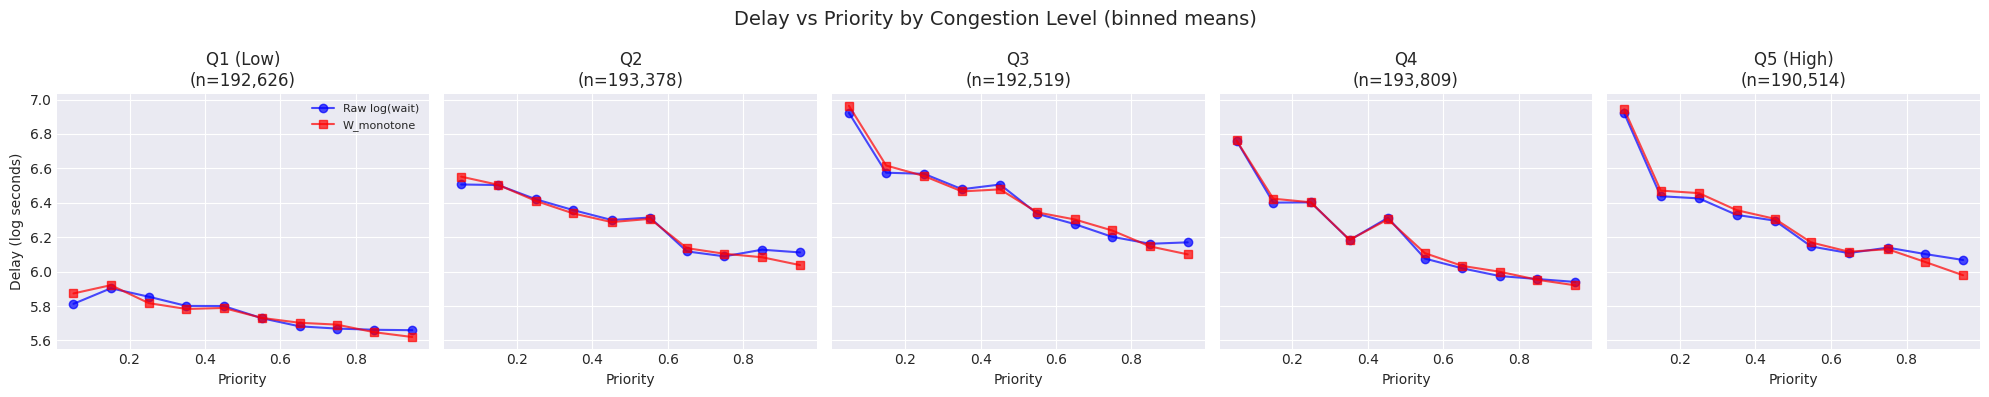


✓ Plot saved to: plots/delay_vs_priority_by_congestion.png

Key insight: The relationship should be STRONGEST in Q5 (high congestion)
because that's when priority actually matters for getting into blocks quickly.


In [73]:
# =============================================================================
# Section 4.5: Priority-Delay Relationship by Congestion Level
# =============================================================================
# The delay-priority relationship should be STRONGEST during high congestion
# when there's real competition for block space

print("\n" + "=" * 60)
print("PRIORITY-DELAY RELATIONSHIP BY CONGESTION LEVEL")
print("=" * 60)

# Get valid data
df_valid = df[df['W_monotone'].notna() & df['fee_rate_percentile'].notna() & df['mempool_tx_count'].notna()].copy()

# Create congestion quintiles
df_valid['congestion_quintile'] = pd.qcut(df_valid['mempool_tx_count'], q=5, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4', 'Q5 (High)'])

# Analyze relationship by congestion level
print("\nCorrelation(priority, delay) by congestion level:")
print("-" * 50)
for q in ['Q1 (Low)', 'Q2', 'Q3', 'Q4', 'Q5 (High)']:
    subset = df_valid[df_valid['congestion_quintile'] == q]
    if len(subset) > 100:
        # Correlation with raw waittime
        corr_raw = subset['fee_rate_percentile'].corr(subset['log_waittime'])
        # Correlation with monotone delay
        corr_monotone = subset['fee_rate_percentile'].corr(subset['W_monotone'])
        # Mean mempool size
        mean_mempool = subset['mempool_tx_count'].mean()
        print(f"  {q}: corr(p, log_wait)={corr_raw:+.4f}, corr(p, W_mono)={corr_monotone:+.4f}, mean_mempool={mean_mempool:,.0f}")

# Plot
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)
fig.suptitle('Delay vs Priority by Congestion Level (binned means)', fontsize=14)

for i, q in enumerate(['Q1 (Low)', 'Q2', 'Q3', 'Q4', 'Q5 (High)']):
    ax = axes[i]
    subset = df_valid[df_valid['congestion_quintile'] == q]
    
    if len(subset) > 100:
        # Create priority bins and compute means
        subset['p_bin'] = pd.cut(subset['fee_rate_percentile'], bins=10, labels=False)
        bin_stats = subset.groupby('p_bin').agg({
            'fee_rate_percentile': 'mean',
            'W_monotone': 'mean',
            'log_waittime': 'mean'
        }).reset_index()
        
        # Plot raw waittime
        ax.plot(bin_stats['fee_rate_percentile'], bin_stats['log_waittime'], 
                'o-', color='blue', alpha=0.7, label='Raw log(wait)')
        # Plot monotone delay
        ax.plot(bin_stats['fee_rate_percentile'], bin_stats['W_monotone'], 
                's-', color='red', alpha=0.7, label='W_monotone')
        
        ax.set_xlabel('Priority')
        ax.set_title(f'{q}\n(n={len(subset):,})')
        if i == 0:
            ax.set_ylabel('Delay (log seconds)')
            ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('/home/kristian/notebooks/plots/delay_vs_priority_by_congestion.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved to: plots/delay_vs_priority_by_congestion.png")
print("\nKey insight: The relationship should be STRONGEST in Q5 (high congestion)")
print("because that's when priority actually matters for getting into blocks quickly.")

FEE RATE DISTRIBUTION ANALYSIS FOR EPSILON SELECTION

Total transactions: 962,846

Fee rate statistics (sat/vB):
  Min:    0.00
  1%:     0.29
  5%:     1.00
  10%:    1.01
  25%:    1.62
  Median: 3.00
  75%:    4.56
  90%:    7.26
  95%:    10.06
  99%:    31.58
  Max:    2017.86

Most common fee rates (potential defaults):
     1.0 sat/vB:  135,296 txs (14.05%, cumulative:  14.1%)
     2.0 sat/vB:  105,363 txs (10.94%, cumulative:  25.0%)
     3.0 sat/vB:   91,117 txs ( 9.46%, cumulative:  34.5%)
     4.0 sat/vB:   65,247 txs ( 6.78%, cumulative:  41.2%)
     1.2 sat/vB:   40,322 txs ( 4.19%, cumulative:  45.4%)
     5.0 sat/vB:   38,286 txs ( 3.98%, cumulative:  49.4%)
     2.3 sat/vB:   31,343 txs ( 3.26%, cumulative:  52.7%)
     1.1 sat/vB:   25,330 txs ( 2.63%, cumulative:  55.3%)
     2.2 sat/vB:   21,747 txs ( 2.26%, cumulative:  57.5%)
     6.0 sat/vB:   19,458 txs ( 2.02%, cumulative:  59.6%)
     2.4 sat/vB:   17,518 txs ( 1.82%, cumulative:  61.4%)
     2.1 sat/vB:   17,4

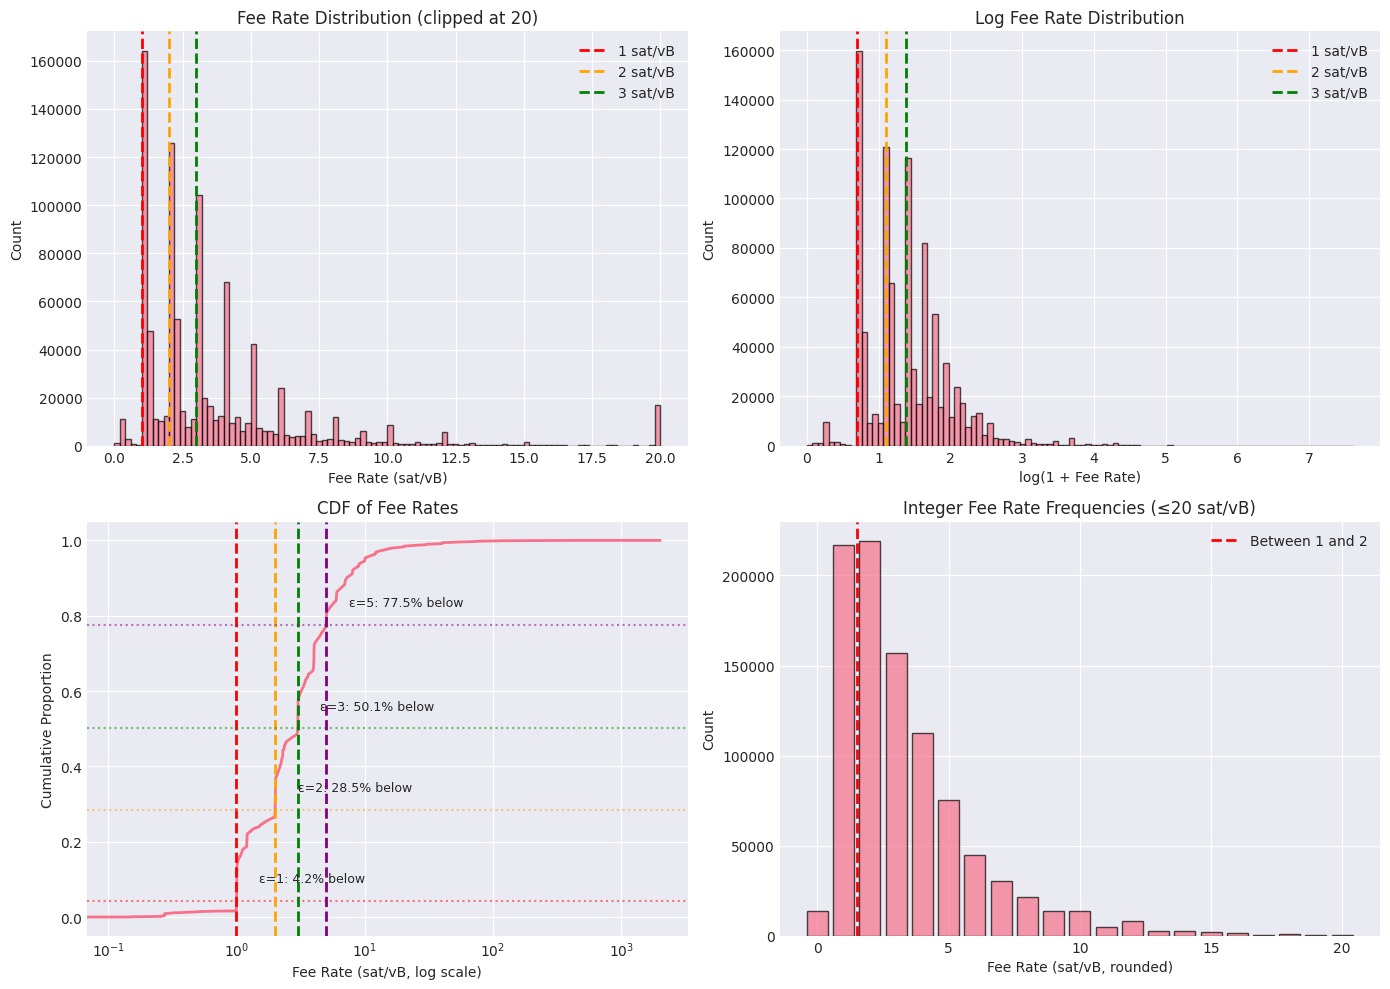


EPSILON RECOMMENDATIONS

ε = 1 sat/vB:
  'Default payers' (fee ≤ ε): 40,459 (4.2%)
  'Active payers' (fee > ε):  922,387 (95.8%)

ε = 2 sat/vB:
  'Default payers' (fee ≤ ε): 274,732 (28.5%)
  'Active payers' (fee > ε):  688,114 (71.5%)

ε = 3 sat/vB:
  'Default payers' (fee ≤ ε): 482,413 (50.1%)
  'Active payers' (fee > ε):  480,433 (49.9%)

ε = 5 sat/vB:
  'Default payers' (fee ≤ ε): 745,781 (77.5%)
  'Active payers' (fee > ε):  217,065 (22.5%)

✓ Plot saved to: plots/fee_rate_distribution.png


In [74]:
# =============================================================================
# Section 4.6: Fee Rate Distribution for Epsilon Selection
# =============================================================================
# Goal: Find a good threshold (epsilon) to separate:
#   - "Default payers" who don't optimize their fee (fee <= epsilon)
#   - "Active payers" who choose their fee strategically (fee > epsilon)

print("=" * 60)
print("FEE RATE DISTRIBUTION ANALYSIS FOR EPSILON SELECTION")
print("=" * 60)

# Get valid fee rates
fee_rates = df['fee_rate'].dropna()
print(f"\nTotal transactions: {len(fee_rates):,}")

# Basic statistics
print(f"\nFee rate statistics (sat/vB):")
print(f"  Min:    {fee_rates.min():.2f}")
print(f"  1%:     {fee_rates.quantile(0.01):.2f}")
print(f"  5%:     {fee_rates.quantile(0.05):.2f}")
print(f"  10%:    {fee_rates.quantile(0.10):.2f}")
print(f"  25%:    {fee_rates.quantile(0.25):.2f}")
print(f"  Median: {fee_rates.median():.2f}")
print(f"  75%:    {fee_rates.quantile(0.75):.2f}")
print(f"  90%:    {fee_rates.quantile(0.90):.2f}")
print(f"  95%:    {fee_rates.quantile(0.95):.2f}")
print(f"  99%:    {fee_rates.quantile(0.99):.2f}")
print(f"  Max:    {fee_rates.max():.2f}")

# Most common fee rates (likely defaults)
# Round to 1 decimal to group similar rates (avoids floating point noise)
print(f"\nMost common fee rates (potential defaults):")
fee_rates_rounded = fee_rates.round(1)
top_fees = fee_rates_rounded.value_counts().head(20)
cumsum = 0
for fee, count in top_fees.items():
    pct = count / len(fee_rates) * 100
    cumsum += pct
    print(f"  {fee:6.1f} sat/vB: {count:>8,} txs ({pct:5.2f}%, cumulative: {cumsum:5.1f}%)")

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogram of fee rates (linear scale, clipped)
ax = axes[0, 0]
ax.hist(fee_rates.clip(upper=20), bins=100, edgecolor='black', alpha=0.7)
ax.axvline(x=1, color='red', linestyle='--', linewidth=2, label='1 sat/vB')
ax.axvline(x=2, color='orange', linestyle='--', linewidth=2, label='2 sat/vB')
ax.axvline(x=3, color='green', linestyle='--', linewidth=2, label='3 sat/vB')
ax.set_xlabel('Fee Rate (sat/vB)')
ax.set_ylabel('Count')
ax.set_title('Fee Rate Distribution (clipped at 20)')
ax.legend()

# 2. Histogram of fee rates (log scale)
ax = axes[0, 1]
log_fees = np.log1p(fee_rates)
ax.hist(log_fees, bins=100, edgecolor='black', alpha=0.7)
ax.axvline(x=np.log1p(1), color='red', linestyle='--', linewidth=2, label='1 sat/vB')
ax.axvline(x=np.log1p(2), color='orange', linestyle='--', linewidth=2, label='2 sat/vB')
ax.axvline(x=np.log1p(3), color='green', linestyle='--', linewidth=2, label='3 sat/vB')
ax.set_xlabel('log(1 + Fee Rate)')
ax.set_ylabel('Count')
ax.set_title('Log Fee Rate Distribution')
ax.legend()

# 3. CDF with candidate epsilon values
ax = axes[1, 0]
sorted_fees = np.sort(fee_rates)
cdf = np.arange(1, len(sorted_fees) + 1) / len(sorted_fees)
# Subsample for plotting
idx = np.linspace(0, len(sorted_fees)-1, 10000).astype(int)
ax.plot(sorted_fees[idx], cdf[idx], linewidth=2)
ax.set_xscale('log')
ax.set_xlabel('Fee Rate (sat/vB, log scale)')
ax.set_ylabel('Cumulative Proportion')
ax.set_title('CDF of Fee Rates')

# Mark candidate epsilon values
for eps, color, label in [(1, 'red', 'ε=1'), (2, 'orange', 'ε=2'), (3, 'green', 'ε=3'), (5, 'purple', 'ε=5')]:
    prop_below = (fee_rates <= eps).mean()
    ax.axvline(x=eps, color=color, linestyle='--', linewidth=2)
    ax.axhline(y=prop_below, color=color, linestyle=':', alpha=0.5)
    ax.annotate(f'{label}: {prop_below:.1%} below', xy=(eps, prop_below), 
                xytext=(eps*1.5, prop_below+0.05), fontsize=9)

# 4. Bar chart of fee rate frequencies (integer values)
ax = axes[1, 1]
int_fees = fee_rates[fee_rates <= 20].round().astype(int)
fee_counts = int_fees.value_counts().sort_index()
ax.bar(fee_counts.index, fee_counts.values, edgecolor='black', alpha=0.7)
ax.set_xlabel('Fee Rate (sat/vB, rounded)')
ax.set_ylabel('Count')
ax.set_title('Integer Fee Rate Frequencies (≤20 sat/vB)')
ax.axvline(x=1.5, color='red', linestyle='--', linewidth=2, label='Between 1 and 2')
ax.legend()

plt.tight_layout()
plt.savefig('/home/kristian/notebooks/plots/fee_rate_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Recommendation
print("\n" + "=" * 60)
print("EPSILON RECOMMENDATIONS")
print("=" * 60)
for eps in [1, 2, 3, 5]:
    n_below = (fee_rates <= eps).sum()
    n_above = (fee_rates > eps).sum()
    pct_below = n_below / len(fee_rates) * 100
    print(f"\nε = {eps} sat/vB:")
    print(f"  'Default payers' (fee ≤ ε): {n_below:,} ({pct_below:.1f}%)")
    print(f"  'Active payers' (fee > ε):  {n_above:,} ({100-pct_below:.1f}%)")

print("\n✓ Plot saved to: plots/fee_rate_distribution.png")

CPFP PACKAGE ANALYSIS (POST-COLLAPSE)

Total observations (after collapse): 962,846
  CPFP packages: 112,794 (11.71%)
  Non-CPFP transactions: 850,052 (88.29%)

--------------------------------------------------
CPFP Package Fee Rate Transformation
--------------------------------------------------

Original Parent Fee Rates (sat/vB):
  Mean:   2.85
  Median: 1.70
  Zero-fee parents: 546 (0.5%)

Package Fee Rates (sat/vB):
  Mean:   3.38
  Median: 2.15
  Zero-fee packages: 0 (0.0%)

Fee Rate Increase:
  Mean increase: 0.53 sat/vB
  Median increase: 0.00 sat/vB

--------------------------------------------------
Fee Rate Distribution by Type
--------------------------------------------------

CPFP Package Fee Rates:
  Mean:   3.38
  Median: 2.15
  Std:    5.79

Non-CPFP Transaction Fee Rates:
  Mean:   4.43
  Median: 3.01
  Std:    11.49


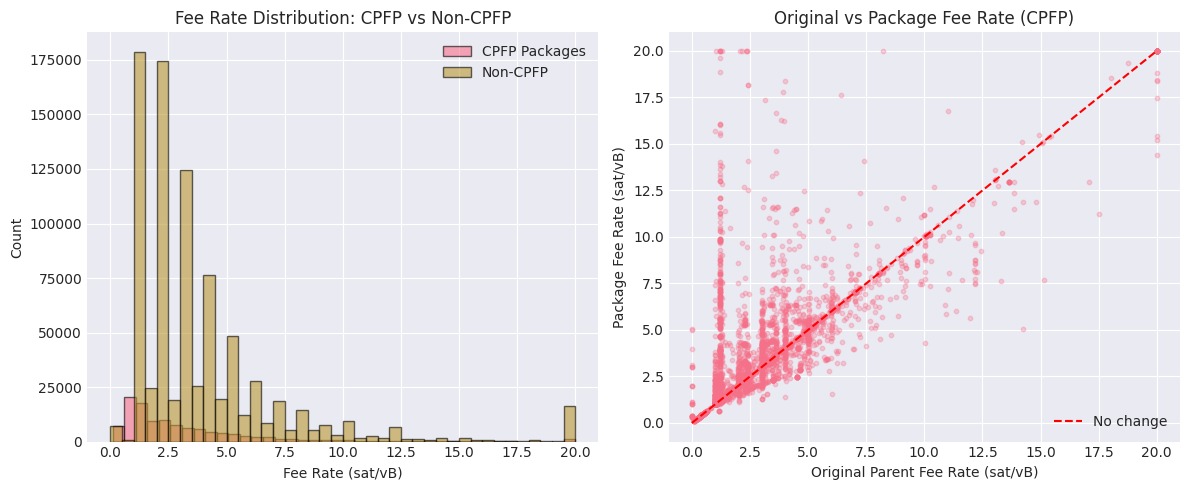


✓ Plot saved to: plots/cpfp_package_analysis.png


In [75]:
# =============================================================================
# Section 4.7: CPFP Package Analysis (Post-Collapse)
# =============================================================================
# Analyze the effect of CPFP package collapsing on fee rate distribution
# Note: CPFP pairs have been collapsed to single observations using package fee rate

print("=" * 60)
print("CPFP PACKAGE ANALYSIS (POST-COLLAPSE)")
print("=" * 60)

# After CPFP collapse, analyze the transformed data
# is_cpfp_package=1 indicates this is a collapsed parent-child pair
cpfp_packages = df[df['is_cpfp_package'] == 1].copy()
non_cpfp = df[df['is_cpfp_package'] == 0].copy()

print(f"\nTotal observations (after collapse): {len(df):,}")
print(f"  CPFP packages: {len(cpfp_packages):,} ({len(cpfp_packages)/len(df)*100:.2f}%)")
print(f"  Non-CPFP transactions: {len(non_cpfp):,} ({len(non_cpfp)/len(df)*100:.2f}%)")

# Analyze original vs package fee rates for CPFP packages
if 'original_fee_rate' in cpfp_packages.columns and len(cpfp_packages) > 0:
    print("\n" + "-" * 50)
    print("CPFP Package Fee Rate Transformation")
    print("-" * 50)
    
    # Stats on original parent fee rates
    orig_rates = cpfp_packages['original_fee_rate']
    pkg_rates = cpfp_packages['fee_rate']
    
    print(f"\nOriginal Parent Fee Rates (sat/vB):")
    print(f"  Mean:   {orig_rates.mean():.2f}")
    print(f"  Median: {orig_rates.median():.2f}")
    print(f"  Zero-fee parents: {(orig_rates == 0).sum():,} ({(orig_rates == 0).mean()*100:.1f}%)")
    
    print(f"\nPackage Fee Rates (sat/vB):")
    print(f"  Mean:   {pkg_rates.mean():.2f}")
    print(f"  Median: {pkg_rates.median():.2f}")
    print(f"  Zero-fee packages: {(pkg_rates == 0).sum():,} ({(pkg_rates == 0).mean()*100:.1f}%)")
    
    print(f"\nFee Rate Increase:")
    fee_increase = pkg_rates - orig_rates
    print(f"  Mean increase: {fee_increase.mean():.2f} sat/vB")
    print(f"  Median increase: {fee_increase.median():.2f} sat/vB")

# Compare fee rate distributions
print("\n" + "-" * 50)
print("Fee Rate Distribution by Type")
print("-" * 50)

print(f"\nCPFP Package Fee Rates:")
print(f"  Mean:   {cpfp_packages['fee_rate'].mean():.2f}")
print(f"  Median: {cpfp_packages['fee_rate'].median():.2f}")
print(f"  Std:    {cpfp_packages['fee_rate'].std():.2f}")

print(f"\nNon-CPFP Transaction Fee Rates:")
print(f"  Mean:   {non_cpfp['fee_rate'].mean():.2f}")
print(f"  Median: {non_cpfp['fee_rate'].median():.2f}")
print(f"  Std:    {non_cpfp['fee_rate'].std():.2f}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Compare fee rate distributions
ax = axes[0]
if len(cpfp_packages) > 0:
    ax.hist(cpfp_packages['fee_rate'].clip(upper=20), bins=40, alpha=0.6, 
            label='CPFP Packages', edgecolor='black')
ax.hist(non_cpfp['fee_rate'].clip(upper=20), bins=40, alpha=0.6, 
        label='Non-CPFP', edgecolor='black')
ax.set_xlabel('Fee Rate (sat/vB)')
ax.set_ylabel('Count')
ax.set_title('Fee Rate Distribution: CPFP vs Non-CPFP')
ax.legend()

# Compare original vs package fee rate for CPFP
ax = axes[1]
if 'original_fee_rate' in df.columns and len(cpfp_packages) > 0:
    sample = cpfp_packages.sample(min(5000, len(cpfp_packages)))
    ax.scatter(sample['original_fee_rate'].clip(upper=20), 
               sample['fee_rate'].clip(upper=20), 
               alpha=0.3, s=10)
    ax.plot([0, 20], [0, 20], 'r--', label='No change')
    ax.set_xlabel('Original Parent Fee Rate (sat/vB)')
    ax.set_ylabel('Package Fee Rate (sat/vB)')
    ax.set_title('Original vs Package Fee Rate (CPFP)')
    ax.legend()
else:
    ax.text(0.5, 0.5, 'No CPFP packages', ha='center', va='center')
    ax.set_title('CPFP Package Analysis')

plt.tight_layout()
plt.savefig('/home/kristian/notebooks/plots/cpfp_package_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved to: plots/cpfp_package_analysis.png")

---
## Section 5: Stage 2 - Hurdle Fee Model

The hurdle model estimates two components (Section 5.4):

1. **Extensive Margin**: P(D_it = 1 | ·) - probability of paying a meaningful fee
   - Binary outcome: D_it = 1{b_it > ε}
   - Logistic regression with constrained spline on impatience

2. **Intensive Margin**: E[log b_it | b_it > ε, ·] - conditional log-fee among payers
   - Ridge regression on log(fee)
   - Smearing correction (ψ) to recover level predictions

**Key**: Priority (p) does NOT appear directly - it enters only through log_Wprime from Stage 1

In [76]:
# =============================================================================
# Section 5.1: I-Spline Transformer
# =============================================================================

class ISplineTransformer:
    """
    I-Spline (Integrated Spline) transformer for monotone regression.
    
    I-splines are monotone increasing by construction. With non-negative
    coefficients, the linear combination is guaranteed monotone.
    
    Reference: Ramsay (1988), "Monotone Regression Splines in Action"
    
    Attributes:
        n_knots: Number of interior knots
        degree: Polynomial degree (default 3 for cubic)
        knots: Full knot sequence including boundary knots
    """
    
    def __init__(self, n_knots: int = 4, degree: int = 3):
        """
        Initialize I-Spline transformer.
        
        Args:
            n_knots: Number of interior knots
            degree: Polynomial degree
        """
        self.n_knots = n_knots
        self.degree = degree
        self.knots = None
        self._x_min = None
        self._x_max = None
        self._is_fitted = False
    
    def fit(self, X: np.ndarray) -> 'ISplineTransformer':
        """
        Fit the transformer by determining knot locations.
        
        Knots are placed at quantiles of X for robustness.
        
        Args:
            X: 1D array of values
            
        Returns:
            self
        """
        X = np.asarray(X).flatten()
        self._x_min = X.min()
        self._x_max = X.max()
        
        # Place interior knots at quantiles
        quantiles = np.linspace(0, 1, self.n_knots + 2)[1:-1]
        interior_knots = np.quantile(X, quantiles)
        
        # Build full knot sequence with boundary repetitions
        # For B-splines of degree k, we need k+1 knots at each boundary
        boundary_low = np.repeat(self._x_min, self.degree + 1)
        boundary_high = np.repeat(self._x_max, self.degree + 1)
        
        self.knots = np.concatenate([boundary_low, interior_knots, boundary_high])
        self._is_fitted = True
        
        return self
    
    def transform(self, X: np.ndarray) -> np.ndarray:
        """
        Transform X to I-spline basis.
        
        I-splines are computed by integrating B-splines using scipy's 
        BSpline.antiderivative() for numerical accuracy.
        
        Args:
            X: 1D array of values
            
        Returns:
            2D array of shape (len(X), n_basis)
        """
        if not self._is_fitted:
            raise RuntimeError("Transformer must be fitted before transform")
        
        X = np.asarray(X).flatten()
        from scipy import interpolate
        
        # Number of basis functions = len(knots) - degree - 1
        n_basis = len(self.knots) - self.degree - 1
        
        # Build I-splines by integrating each B-spline
        I_basis = np.zeros((len(X), n_basis))
        
        for j in range(n_basis):
            # Create B-spline with unit coefficient at position j
            c = np.zeros(n_basis)
            c[j] = 1.0
            
            bspl = interpolate.BSpline(self.knots, c, self.degree)
            
            # Get antiderivative (integrated B-spline)
            ibspl = bspl.antiderivative()
            
            # Evaluate I-spline: integral from x_min to x
            I_basis[:, j] = ibspl(X) - ibspl(self._x_min)
        
        # Normalize each column by its maximum (so I-splines range from 0 to 1)
        max_vals = I_basis.max(axis=0)
        max_vals[max_vals == 0] = 1  # Avoid division by zero
        I_basis = I_basis / max_vals
        
        return I_basis
    
    def fit_transform(self, X: np.ndarray) -> np.ndarray:
        """Fit and transform in one step."""
        return self.fit(X).transform(X)
    
    @property
    def n_basis(self) -> int:
        """Number of basis functions."""
        if self.knots is None:
            # Estimate before fitting
            return self.n_knots + self.degree + 1
        return len(self.knots) - self.degree - 1

# Test the I-Spline transformer
print("I-Spline Transformer created")
print("Testing on sample data...")
x_test = np.linspace(0, 1, 100)
ispline = ISplineTransformer(n_knots=4, degree=3)
basis = ispline.fit_transform(x_test)
print(f"  Input shape: {x_test.shape}")
print(f"  Output shape: {basis.shape}")
print(f"  Basis functions are monotone: {np.all(np.diff(basis, axis=0) >= -1e-10)}")

I-Spline Transformer created
Testing on sample data...
  Input shape: (100,)
  Output shape: (100, 8)
  Basis functions are monotone: True


In [77]:
# =============================================================================
# Section 5.2: Constrained Estimation Functions
# =============================================================================

def fit_constrained_ols(X: np.ndarray, y: np.ndarray, n_spline: int,
                        monotone_direction: str = 'increasing') -> np.ndarray:
    """
    Fit OLS with constraints on spline coefficients for monotonicity.
    
    Args:
        X: Feature matrix (first n_spline columns are spline basis)
        y: Target variable
        n_spline: Number of spline coefficients to constrain
        monotone_direction: 'increasing', 'decreasing', or 'none'
        
    Returns:
        Coefficient array
    """
    n_total = X.shape[1]
    
    if monotone_direction == 'increasing':
        lb = np.concatenate([np.zeros(n_spline), np.full(n_total - n_spline, -np.inf)])
        ub = np.full(n_total, np.inf)
    elif monotone_direction == 'decreasing':
        lb = np.full(n_total, -np.inf)
        ub = np.concatenate([np.zeros(n_spline), np.full(n_total - n_spline, np.inf)])
    else:  # 'none'
        lb = np.full(n_total, -np.inf)
        ub = np.full(n_total, np.inf)
    
    result = lsq_linear(X, y, bounds=(lb, ub))
    
    return result.x


def fit_constrained_logistic(X: np.ndarray, y: np.ndarray, n_spline: int,
                             monotone_direction: str = 'increasing',
                             max_iter: int = 1000) -> np.ndarray:
    """
    Fit logistic regression with constraints on spline coefficients for monotonicity.
    
    Args:
        X: Feature matrix (first n_spline columns are spline basis)
        y: Binary target variable
        n_spline: Number of spline coefficients to constrain
        monotone_direction: 'increasing', 'decreasing', or 'none'
        max_iter: Maximum optimization iterations
        
    Returns:
        Coefficient array
    """
    n_total = X.shape[1]
    
    def neg_log_likelihood(beta):
        """Negative log-likelihood for logistic regression."""
        linear_pred = X @ beta
        # Clip to avoid overflow
        linear_pred = np.clip(linear_pred, -500, 500)
        ll = np.sum(y * linear_pred - np.log1p(np.exp(linear_pred)))
        return -ll
    
    def gradient(beta):
        """Gradient of negative log-likelihood."""
        linear_pred = X @ beta
        linear_pred = np.clip(linear_pred, -500, 500)
        prob = 1 / (1 + np.exp(-linear_pred))
        return -X.T @ (y - prob)
    
    # Initial values
    x0 = np.zeros(n_total)
    
    # Set bounds based on monotone direction
    if monotone_direction == 'increasing':
        bounds = [(0, None)] * n_spline + [(None, None)] * (n_total - n_spline)
    elif monotone_direction == 'decreasing':
        bounds = [(None, 0)] * n_spline + [(None, None)] * (n_total - n_spline)
    else:  # 'none'
        bounds = [(None, None)] * n_total
    
    result = minimize(
        neg_log_likelihood,
        x0,
        method='L-BFGS-B',
        jac=gradient,
        bounds=bounds,
        options={'maxiter': max_iter, 'disp': False}
    )
    
    return result.x

def fit_regularized_ols(X: np.ndarray, y: np.ndarray, alpha: float = 1.0) -> np.ndarray:
    """
    Fit Ridge regression (L2 regularized) - no monotonicity constraint.
    """
    from sklearn.linear_model import Ridge
    model = Ridge(alpha=alpha, fit_intercept=False)
    model.fit(X, y)
    return model.coef_

print("Constrained + regularized estimation functions defined")

Constrained + regularized estimation functions defined


In [78]:
# =============================================================================
# Section 5.3: HurdleFeeModel Class (WITH EPOCH FIXED EFFECTS)
# =============================================================================

class HurdleFeeModel:
    """
    Stage 2: Hurdle model for fee estimation with epoch fixed effects.

    Estimates two components:
    1. Extensive margin: P(fee > ε | X) using logistic regression
    2. Intensive margin: E[log(fee) | fee > ε, X] using OLS

    Both models use I-splines on impatience. Monotonicity direction is auto-detected:
    - 'increasing': fee increases with impatience (constrain coeffs >= 0)
    - 'decreasing': fee decreases with impatience (constrain coeffs <= 0)  
    - 'none': no monotonicity constraint (unconstrained spline)
    - 'auto': detect direction from correlation (default)
    Epoch fixed effects absorb time-varying congestion shocks.

    Attributes:
        config: EstimationConfig object
        ispline: ISplineTransformer for impatience
        ext_coefs: Coefficients for extensive margin
        int_coefs: Coefficients for intensive margin
        smearing_factor: Duan's smearing factor for retransformation
        epoch_labels: Unique epoch IDs seen during training
    """

    # Feature columns (excluding impatience which gets splined, and epoch_id which gets dummified)
    CONTROL_FEATURES = ['log_Wprime', 'log_weight', 'has_rbf', 'is_cpfp_package', 'log_total_output']
    STATE_FEATURES = ['log_congestion', 'blockspace_utilization']

    def __init__(self, config: EstimationConfig, use_epoch_fe: bool = False,
                 monotone_direction: str = 'auto', use_ridge: bool = False, 
                 ridge_alpha: float = 1.0):
        """Initialize the hurdle model.

        Args:
            config: EstimationConfig object
            use_epoch_fe: Whether to include epoch fixed effects (default True)
            monotone_direction: 'increasing', 'decreasing', 'none', or 'auto' (default)
            use_ridge: If True, use Ridge regression instead of constrained OLS (recommended)
            ridge_alpha: Regularization strength for Ridge (higher = more regularization)
        """
        self.config = config
        self.use_epoch_fe = use_epoch_fe
        self.monotone_direction = monotone_direction
        self._detected_direction = None
        self.use_ridge = use_ridge
        self.ridge_alpha = ridge_alpha
        self.ispline = ISplineTransformer(
            n_knots=config.spline_n_knots,
            degree=config.spline_degree
        )
        self.ext_coefs = None
        self.int_coefs = None
        self.smearing_factor = None
        self._is_fitted = False
        self._feature_names = None
        self.epoch_labels = None  # Store epoch labels for prediction
        self._n_epoch_dummies = 0

    def _build_feature_matrix(self, df: pd.DataFrame, fit_spline: bool = False) -> Tuple[np.ndarray, List[str]]:
        """
        Build the feature matrix with I-spline basis for impatience and epoch FE.

        Args:
            df: DataFrame with features
            fit_spline: Whether to fit the spline transformer

        Returns:
            Tuple of (feature_matrix, feature_names)
        """
        # Get impatience values
        impatience = df['log_impatience'].values

        # Fit or transform spline
        if fit_spline:
            spline_basis = self.ispline.fit_transform(impatience)
        else:
            spline_basis = self.ispline.transform(impatience)

        # Get other features
        control_vals = df[self.CONTROL_FEATURES].values
        state_vals = df[self.STATE_FEATURES].values

        # Feature names (before epoch FE)
        spline_names = [f'ispline_{i}' for i in range(self.ispline.n_basis)]
        feature_names = spline_names + self.CONTROL_FEATURES + self.STATE_FEATURES

        # Build base feature matrix
        X = np.hstack([spline_basis, control_vals, state_vals])

        # Add epoch fixed effects if enabled
        if self.use_epoch_fe:
            if fit_spline:
                # During fitting: learn epoch labels
                self.epoch_labels = sorted(df['epoch_id'].unique())
                # Drop first epoch for identification (reference category)
                self.epoch_labels_for_dummies = self.epoch_labels[1:]
                self._n_epoch_dummies = len(self.epoch_labels_for_dummies)
                print(f"  Epoch fixed effects: {self._n_epoch_dummies} dummies (from {len(self.epoch_labels)} epochs)")

            # Create epoch dummies
            epoch_dummies = np.zeros((len(df), self._n_epoch_dummies))
            epoch_ids = df['epoch_id'].values

            for i, epoch in enumerate(self.epoch_labels_for_dummies):
                epoch_dummies[:, i] = (epoch_ids == epoch).astype(float)

            X = np.hstack([X, epoch_dummies])

            # Add epoch names to feature names
            epoch_names = [f'epoch_{e}' for e in self.epoch_labels_for_dummies]
            feature_names = feature_names + epoch_names

        return X, feature_names

    def fit(self, df: pd.DataFrame) -> 'HurdleFeeModel':
        """
        Fit the hurdle model.

        Args:
            df: DataFrame with all features including log_Wprime from Stage 1

        Returns:
            self
        """
        print("\n" + "=" * 60)
        print("STAGE 2: Fitting Hurdle Fee Model" + (" (with Epoch FE)" if self.use_epoch_fe else ""))
        print("=" * 60)

        # Check required columns
        required = ['log_impatience', 'log_Wprime', 'fee_rate', 'epoch_id'] + self.CONTROL_FEATURES + self.STATE_FEATURES
        missing = [c for c in required if c not in df.columns]
        if missing:
            raise ValueError(f"Missing columns: {missing}")

        # Filter to valid observations (non-null Stage 1 outputs)
        valid_mask = (
            df['log_impatience'].notna() &
            df['log_Wprime'].notna() &
            df['fee_rate'].notna() &
            df['epoch_id'].notna()
        )
        df_valid = df[valid_mask].copy()

        print(f"Fitting on {len(df_valid):,} valid observations")

        # Determine monotonicity direction from correlation
        if self.monotone_direction == 'auto':
            valid_fee_mask = df_valid['fee_rate'] > self.config.fee_threshold_sat_vb
            if valid_fee_mask.sum() > 100:
                corr = df_valid.loc[valid_fee_mask, 'log_impatience'].corr(
                    np.log(df_valid.loc[valid_fee_mask, 'fee_rate']))
                print(f"\nCorrelation(log_impatience, log_fee_rate): {corr:.4f}")
                if corr > 0.05:
                    self._detected_direction = 'increasing'
                    print(f"  -> Using INCREASING monotonicity (coeffs >= 0)")
                elif corr < -0.05:
                    self._detected_direction = 'decreasing'
                    print(f"  -> Using DECREASING monotonicity (coeffs <= 0)")
                else:
                    self._detected_direction = 'none'
                    print(f"  -> Weak correlation, NO monotonicity constraint")
            else:
                self._detected_direction = 'none'
        else:
            self._detected_direction = self.monotone_direction
            print(f"\nUsing monotonicity direction: {self._detected_direction}")

        # Create binary indicator for extensive margin
        eps = self.config.fee_threshold_sat_vb
        df_valid['D'] = (df_valid['fee_rate'] > eps).astype(int)

        print(f"\nHurdle threshold: {eps} sat/vB")
        print(f"  D=1 (fee > ε): {df_valid['D'].sum():,} ({df_valid['D'].mean()*100:.1f}%)")
        print(f"  D=0 (fee <= ε): {(1-df_valid['D']).sum():,} ({(1-df_valid['D']).mean()*100:.1f}%)")

        # Build feature matrix (this also fits the spline and learns epoch labels)
        X, self._feature_names = self._build_feature_matrix(df_valid, fit_spline=True)
        n_spline = self.ispline.n_basis

        print(f"\nFeature matrix shape: {X.shape}")
        print(f"  Spline basis functions: {n_spline}")
        print(f"  Control features: {len(self.CONTROL_FEATURES)}")
        print(f"  State features: {len(self.STATE_FEATURES)}")
        if self.use_epoch_fe:
            print(f"  Epoch FE dummies: {self._n_epoch_dummies}")

        # =================================================================
        # Extensive Margin: P(D = 1 | X)
        # =================================================================
        print("\nFitting extensive margin (logistic)...")
        y_ext = df_valid['D'].values

        # Add intercept
        X_ext = np.hstack([np.ones((len(df_valid), 1)), X])

        # Only constrain spline coefficients (first n_spline+1 including intercept)
        self.ext_coefs = fit_constrained_logistic(X_ext, y_ext, n_spline + 1, self._detected_direction)

        # Compute in-sample accuracy
        prob_ext = 1 / (1 + np.exp(-X_ext @ self.ext_coefs))
        pred_ext = (prob_ext > 0.5).astype(int)
        accuracy = (pred_ext == y_ext).mean()
        print(f"  Extensive margin accuracy: {accuracy*100:.1f}%")

        # =================================================================
        # Intensive Margin: E[log(fee) | fee > ε, X]
        # =================================================================
        print("\nFitting intensive margin (OLS)...")

        # Filter to fee-payers
        payer_mask = df_valid['D'] == 1
        df_payers = df_valid[payer_mask]

        if len(df_payers) < 100:
            raise ValueError(f"Too few fee-payers ({len(df_payers)}) for intensive margin")

        y_int = np.log(df_payers['fee_rate'].values)
        X_int_base, _ = self._build_feature_matrix(df_payers, fit_spline=False)
        X_int = np.hstack([np.ones((len(df_payers), 1)), X_int_base])

        # Fit intensive margin
        if self.use_ridge:
            print(f"  Using Ridge regression (alpha={self.ridge_alpha})")
            self.int_coefs = fit_regularized_ols(X_int, y_int, alpha=self.ridge_alpha)
        else:
            self.int_coefs = fit_constrained_ols(X_int, y_int, n_spline + 1, self._detected_direction)

        # Compute residuals and smearing factor
        y_pred_int = X_int @ self.int_coefs
        residuals = y_int - y_pred_int
        self.smearing_factor = np.mean(np.exp(residuals))

        # R-squared
        ss_res = np.sum(residuals ** 2)
        ss_tot = np.sum((y_int - y_int.mean()) ** 2)
        r2 = 1 - ss_res / ss_tot

        print(f"  Intensive margin R²: {r2:.4f}")
        print(f"  Smearing factor (ψ): {self.smearing_factor:.4f}")

        self._is_fitted = True

        print("\n✓ Stage 2 fitting complete")

        return self

    def predict_probability(self, df: pd.DataFrame) -> np.ndarray:
        """Predict P(fee > ε | X)."""
        if not self._is_fitted:
            raise RuntimeError("Model must be fitted before prediction")

        X, _ = self._build_feature_matrix(df, fit_spline=False)
        X_ext = np.hstack([np.ones((len(df), 1)), X])

        linear_pred = X_ext @ self.ext_coefs
        prob = 1 / (1 + np.exp(-np.clip(linear_pred, -500, 500)))

        return prob

    def predict_conditional_log_fee(self, df: pd.DataFrame) -> np.ndarray:
        """Predict E[log(fee) | fee > ε, X]."""
        if not self._is_fitted:
            raise RuntimeError("Model must be fitted before prediction")

        X, _ = self._build_feature_matrix(df, fit_spline=False)
        X_int = np.hstack([np.ones((len(df), 1)), X])

        return X_int @ self.int_coefs

    def predict_conditional_fee(self, df: pd.DataFrame) -> np.ndarray:
        """Predict E[fee | fee > ε, X] with smearing correction."""
        log_fee = self.predict_conditional_log_fee(df)
        return np.exp(log_fee) * self.smearing_factor

    def get_coefficient_summary(self) -> pd.DataFrame:
        """Get summary of model coefficients (excluding epoch FE for readability)."""
        if not self._is_fitted:
            raise RuntimeError("Model must be fitted first")

        # Get feature names without epoch dummies for cleaner output
        n_base_features = len(self._feature_names) - self._n_epoch_dummies
        base_feature_names = ['intercept'] + self._feature_names[:n_base_features]

        # Coefficients for base features only
        n_coefs = len(base_feature_names)

        summary = pd.DataFrame({
            'feature': base_feature_names,
            'extensive_coef': self.ext_coefs[:n_coefs],
            'intensive_coef': self.int_coefs[:n_coefs]
        })

        return summary

    def get_epoch_effects(self) -> pd.DataFrame:
        """Get epoch fixed effects from intensive margin."""
        if not self._is_fitted or not self.use_epoch_fe:
            return None

        n_base = 1 + len(self._feature_names) - self._n_epoch_dummies  # intercept + base features
        epoch_coefs = self.int_coefs[n_base:]

        return pd.DataFrame({
            'epoch_id': self.epoch_labels_for_dummies,
            'intensive_fe': epoch_coefs
        })


In [79]:
# =============================================================================
# Section 5.4: Fit Stage 2 Model
# =============================================================================
# Initialize and fit Stage 2 estimator
stage2 = HurdleFeeModel(config, monotone_direction='increasing', use_ridge=True, ridge_alpha=10.0)
high_congestion_mask = df["mempool_tx_count"] >= df["mempool_tx_count"].quantile(0.5)
df_high_congestion = df[high_congestion_mask].copy()
stage2.fit(df_high_congestion)

# Get coefficient summary
coef_summary = stage2.get_coefficient_summary()
print("\nCoefficient Summary:")
print(coef_summary.to_string(index=False))


STAGE 2: Fitting Hurdle Fee Model
Fitting on 481,939 valid observations

Using monotonicity direction: increasing

Hurdle threshold: 2.1 sat/vB
  D=1 (fee > ε): 327,568 (68.0%)
  D=0 (fee <= ε): 154,371 (32.0%)

Feature matrix shape: (481939, 15)
  Spline basis functions: 8
  Control features: 5
  State features: 2

Fitting extensive margin (logistic)...
  Extensive margin accuracy: 73.4%

Fitting intensive margin (OLS)...
  Using Ridge regression (alpha=10.0)
  Intensive margin R²: 0.0473
  Smearing factor (ψ): 1.2975

✓ Stage 2 fitting complete

Coefficient Summary:
               feature  extensive_coef  intensive_coef
             intercept          0.4210          1.4838
             ispline_0          0.0000          0.0000
             ispline_1          0.1390         -0.0546
             ispline_2          0.0000          0.1983
             ispline_3          0.0000         -0.1951
             ispline_4          0.0000          0.1833
             ispline_5          0.0000 

In [80]:
# Check the I-spline basis values
impatience_vals = df['log_impatience'].values
spline_basis = stage2.ispline.transform(impatience_vals)

print("I-Spline basis statistics:")
print(pd.DataFrame(spline_basis).describe())

# Check for near-zero columns
print("\nMin values per column (potential issues if near 0):")
print(spline_basis.min(axis=0))

print("\nMax values per column:")
print(spline_basis.max(axis=0))

# Check what unconstrained coefficients would be
from sklearn.linear_model import LinearRegression

# Get the payers data
payers = df[df['fee_rate'] > 2.1].copy()
X_payers, _ = stage2._build_feature_matrix(payers, fit_spline=False)
X_payers = np.hstack([np.ones((len(payers), 1)), X_payers])
y_payers = np.log(payers['fee_rate'].values)

# Fit unconstrained
model_unc = LinearRegression().fit(X_payers, y_payers)
print("\nUnconstrained spline coefficients:")
for i in range(8):
    print(f"  ispline_{i}: {model_unc.coef_[1+i]:.4f}")
print(f"\nUnconstrained R²: {model_unc.score(X_payers, y_payers):.4f}")

I-Spline basis statistics:
                0           1           2           3           4           5  \
count 962846.0000 962846.0000 962846.0000 962846.0000 962846.0000 962846.0000   
mean       0.0000      0.7182      0.6572      0.5790      0.2049      0.0516   
std        0.0000      0.4342      0.4460      0.4524      0.2408      0.1801   
min        0.0000      0.0000      0.0000      0.0000      0.0000      0.0000   
25%        0.0000      0.0180      0.0001      0.0000      0.0000      0.0000   
50%        0.0000      1.0000      0.9967      0.8662      0.1097      0.0011   
75%        0.0000      1.0000      1.0000      1.0000      0.3890      0.0362   
max        0.0000      1.0000      1.0000      1.0000      1.0000      1.0000   

                6           7  
count 962846.0000 962846.0000  
mean       0.0344      0.0340  
std        0.1813      0.1813  
min        0.0000      0.0000  
25%        0.0000      0.0000  
50%        0.0000      0.0000  
75%        0.0002  

---
## Section 6: Main Pipeline - BitcoinFeeEstimator

The main orchestrator class that combines Stage 1 and Stage 2 into a complete pipeline.

In [81]:
# =============================================================================
# Section 6.1: BitcoinFeeEstimator Class
# =============================================================================

class BitcoinFeeEstimator:
    """
    Main orchestrator for the two-stage fee estimation pipeline.
    
    Combines:
    - Data preparation
    - Stage 1: Delay technology estimation
    - Stage 2: Hurdle fee model
    
    Attributes:
        config: EstimationConfig object
        stage1: DelayTechnologyEstimator
        stage2: HurdleFeeModel
        df_prepared: Prepared DataFrame
    """
    
    def __init__(self, config: Optional[EstimationConfig] = None):
        """
        Initialize the estimator.
        
        Args:
            config: EstimationConfig object (uses defaults if None)
        """
        self.config = config or EstimationConfig()
        self.stage1 = None
        self.stage2 = None
        self.df_prepared = None
        self._is_fitted = False
    
    def fit(self, df: pd.DataFrame) -> 'BitcoinFeeEstimator':
        """
        Fit the complete two-stage model.
        
        Args:
            df: Raw transaction DataFrame
            
        Returns:
            self
        """
        print("\n" + "=" * 60)
        print("BITCOIN FEE ESTIMATION PIPELINE")
        print("=" * 60)
        
        # Step 1: Prepare features
        print("\n[1/4] Preparing features...")
        self.df_prepared = prepare_features(df.copy(), self.config)
        
        # Step 2: Fit Stage 1
        print("\n[2/4] Fitting Stage 1 (Delay Technology)...")
        self.stage1 = DelayTechnologyEstimator(self.config)
        self.stage1.fit(self.df_prepared)
        
        # Step 3: Compute Stage 1 outputs (per-observation isotonic + finite diff)
        print("\n[3/4] Computing Stage 1 outputs...")
        W_hat = self.stage1.predict_W_hat(self.df_prepared)
        W_monotone = self.stage1.predict_delay_monotone_per_obs(self.df_prepared, W_hat, verbose=False)
        Wprime_hat = self.stage1.compute_slope_finite_diff_per_obs(self.df_prepared, W_monotone, delta=0.05, verbose=False)
        
        # Add to DataFrame
        self.df_prepared['W_hat'] = np.nan
        self.df_prepared['W_monotone'] = np.nan
        self.df_prepared['Wprime_hat'] = np.nan
        self.df_prepared.loc[self.stage1._valid_indices, 'W_hat'] = W_hat
        self.df_prepared.loc[self.stage1._valid_indices, 'W_monotone'] = W_monotone
        self.df_prepared.loc[self.stage1._valid_indices, 'Wprime_hat'] = Wprime_hat
        self.df_prepared['log_Wprime'] = np.log(self.df_prepared['Wprime_hat'].clip(lower=1e-6))
        
        # Step 4: Fit Stage 2
        print("\n[4/4] Fitting Stage 2 (Hurdle Fee Model)...")
        self.stage2 = HurdleFeeModel(self.config)
        self.stage2.fit(self.df_prepared)
        
        self._is_fitted = True
        
        print("\n" + "=" * 60)
        print("PIPELINE FITTING COMPLETE")
        print("=" * 60)
        
        return self
    
    def predict(self, df: Optional[pd.DataFrame] = None) -> pd.DataFrame:
        """
        Generate predictions.
        
        Args:
            df: DataFrame to predict on (uses training data if None)
            
        Returns:
            DataFrame with predictions
        """
        if not self._is_fitted:
            raise RuntimeError("Model must be fitted before prediction")
        
        if df is None:
            df = self.df_prepared
        else:
            # Prepare new data
            df = prepare_features(df.copy(), self.config)
            
            # Compute Stage 1 outputs (per-observation isotonic + finite diff)
            W_hat = self.stage1.predict_W_hat(df)
            W_monotone = self.stage1.predict_delay_monotone_per_obs(df, W_hat, verbose=False)
            Wprime_hat = self.stage1.compute_slope_finite_diff_per_obs(df, W_monotone, delta=0.05, verbose=False)
            
            df['W_hat'] = np.nan
            df['W_monotone'] = np.nan
            df['Wprime_hat'] = np.nan
            df.loc[self.stage1._valid_indices, 'W_hat'] = W_hat
            df.loc[self.stage1._valid_indices, 'W_monotone'] = W_monotone
            df.loc[self.stage1._valid_indices, 'Wprime_hat'] = Wprime_hat
            df['log_Wprime'] = np.log(df['Wprime_hat'].clip(lower=1e-6))
        
        # Get predictions
        valid_mask = df['log_Wprime'].notna() & df['log_impatience'].notna()
        df_valid = df[valid_mask].copy()
        
        results = pd.DataFrame({
            'tx_id': df_valid['tx_id'],
            'actual_fee_rate': df_valid['fee_rate'],
            'W_hat': df_valid['W_hat'],
            'Wprime_hat': df_valid['Wprime_hat'],
            'P_fee_gt_eps': self.stage2.predict_probability(df_valid),
            'E_log_fee_conditional': self.stage2.predict_conditional_log_fee(df_valid),
            'E_fee_conditional': self.stage2.predict_conditional_fee(df_valid)
        })
        
        return results
    
    def summary(self) -> Dict[str, Any]:
        """
        Get summary statistics of the fitted model.
        
        Returns:
            Dictionary with summary statistics
        """
        if not self._is_fitted:
            raise RuntimeError("Model must be fitted before getting summary")
        
        return {
            'config': {
                'epoch_duration_minutes': self.config.epoch_duration_minutes,
                'n_folds': self.config.n_folds,
                'fee_threshold': self.config.fee_threshold_sat_vb,
                'spline_knots': self.config.spline_n_knots
            },
            'data': {
                'n_observations': len(self.df_prepared),
                'n_epochs': self.df_prepared['epoch_id'].nunique(),
                'time_range': (
                    str(self.df_prepared['found_at'].min()),
                    str(self.df_prepared['found_at'].max())
                )
            },
            'stage1': {
                'model_type': 'RandomForest',
                'n_valid': len(self.stage1._valid_indices)
            },
            'stage2': {
                'smearing_factor': self.stage2.smearing_factor,
                'n_features': len(self.stage2._feature_names)
            }
        }
    
    def save(self, path: str) -> None:
        """Save the fitted model to disk."""
        if not self._is_fitted:
            raise RuntimeError("Model must be fitted before saving")
        
        joblib.dump({
            'config': self.config,
            'stage1': self.stage1,
            'stage2': self.stage2
        }, path)
        print(f"Model saved to {path}")
    
    @classmethod
    def load(cls, path: str) -> 'BitcoinFeeEstimator':
        """Load a fitted model from disk."""
        data = joblib.load(path)
        
        estimator = cls(data['config'])
        estimator.stage1 = data['stage1']
        estimator.stage2 = data['stage2']
        estimator._is_fitted = True
        
        print(f"Model loaded from {path}")
        return estimator

print("BitcoinFeeEstimator class defined")

BitcoinFeeEstimator class defined


In [82]:
# =============================================================================
# Section 6.2: Run Complete Pipeline
# =============================================================================
# Note: We've already fitted stage1 and stage2 separately above
# This cell demonstrates how to use the unified interface

# Create a new estimator from the already fitted components
estimator = BitcoinFeeEstimator(config)
estimator.stage1 = stage1
estimator.stage2 = stage2
estimator.df_prepared = df
estimator._is_fitted = True

# Get predictions
predictions = estimator.predict()

print("\nPrediction Sample:")
print(predictions.head(10))

# Get summary
summary = estimator.summary()
print("\nModel Summary:")
for section, values in summary.items():
    print(f"\n{section}:")
    if isinstance(values, dict):
        for k, v in values.items():
            print(f"  {k}: {v}")


Prediction Sample:
                                                    tx_id  actual_fee_rate  \
336564  e26dcea5152addff4b7c44e9590860cf7b95a1bb4d1def...           1.0092   
336562  fad1ac83ba4cb7c02baac228986acee4c97d0e2935b2ca...           7.2993   
336563  fa7019d14aabfaa134fd7c220297e2a252ede42afee07e...           4.0244   
336552  b6cad1a3043fdc95e5dbca19f1d592e1192b89dcab950a...           3.2127   
336553  cc64368d585e573183d09d6120e264415fb622d79c2735...           3.1313   
336554  498e4b1f15038d22d1f0139e6e7b3bbccc88e970c53fdc...           2.7027   
336555  3bdcb20abe19f7ae4fd84968894ec9e0c6c232eb12a0f4...           2.3000   
336556  842e6f1a165ba7561694b215318d5c4b02bf8bbe1f34c7...           1.1714   
336557  79a9362d88cc4962701c593b78df35a2aa145223d0ed75...           1.2346   
336558  2e9da5373a77273bfd7b9b7f38fc5fbbfa85753c9b80b4...           1.0000   

        W_hat  Wprime_hat  P_fee_gt_eps  E_log_fee_conditional  \
336564 4.6103      0.0000        0.6629                

---
## Section 7: Diagnostics and Validation

This section includes:
- Clustered standard errors (Liang-Zeger sandwich estimator)
- Diagnostic visualizations
- Model validation plots

In [83]:
# =============================================================================
# Section 7.1: Clustered Standard Errors
# =============================================================================

def compute_clustered_se(X: np.ndarray, residuals: np.ndarray, 
                         cluster_ids: np.ndarray) -> np.ndarray:
    """
    Compute Liang-Zeger cluster-robust standard errors.
    
    The sandwich variance estimator is:
    V = (X'X)^{-1} * (sum_c X_c' e_c e_c' X_c) * (X'X)^{-1}
    
    where c indexes clusters and e_c are residuals for cluster c.
    
    Args:
        X: Feature matrix (n x p)
        residuals: Residual vector (n,)
        cluster_ids: Cluster assignments (n,)
        
    Returns:
        Standard errors for each coefficient (p,)
    """
    n, p = X.shape
    
    # Compute bread: (X'X)^{-1} using pseudo-inverse for numerical stability
    # (handles multicollinearity/singular matrices gracefully)
    XtX_inv = np.linalg.pinv(X.T @ X)
    
    # Compute meat: sum of cluster-specific outer products
    unique_clusters = np.unique(cluster_ids)
    n_clusters = len(unique_clusters)
    
    meat = np.zeros((p, p))
    for c in unique_clusters:
        mask = cluster_ids == c
        X_c = X[mask]
        e_c = residuals[mask]
        
        # Cluster score
        score_c = X_c.T @ e_c
        meat += np.outer(score_c, score_c)
    
    # Small-sample adjustment: (n_clusters / (n_clusters - 1)) * ((n - 1) / (n - p))
    adjustment = (n_clusters / (n_clusters - 1)) * ((n - 1) / (n - p))
    
    # Sandwich variance
    V = XtX_inv @ (adjustment * meat) @ XtX_inv
    
    # Standard errors
    se = np.sqrt(np.diag(V))
    
    return se


def compute_intensive_margin_se(stage2: HurdleFeeModel, df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute clustered standard errors for the intensive margin coefficients.
    
    Args:
        stage2: Fitted HurdleFeeModel
        df: DataFrame with features and epoch_id
        
    Returns:
        DataFrame with coefficients and standard errors
    """
    print("Computing clustered standard errors for intensive margin...")
    
    # Get feature matrix and outcomes for fee-payers
    eps = stage2.config.fee_threshold_sat_vb
    valid_mask = (
        df['log_impatience'].notna() &
        df['log_Wprime'].notna() &
        df['fee_rate'].notna() &
        (df['fee_rate'] > eps)
    )
    df_payers = df[valid_mask].copy()
    
    # Build feature matrix
    X_base, feature_names = stage2._build_feature_matrix(df_payers, fit_spline=False)
    X = np.hstack([np.ones((len(df_payers), 1)), X_base])
    
    # Compute residuals
    y = np.log(df_payers['fee_rate'].values)
    y_pred = X @ stage2.int_coefs
    residuals = y - y_pred
    
    # Get cluster IDs
    cluster_ids = df_payers['epoch_id'].values
    
    # Compute clustered SEs
    se_clustered = compute_clustered_se(X, residuals, cluster_ids)
    
    # Also compute naive (OLS) SEs for comparison
    n = len(y)
    sigma2 = np.sum(residuals ** 2) / (n - X.shape[1])
    XtX_inv = np.linalg.pinv(X.T @ X)  # pseudo-inverse for numerical stability
    se_naive = np.sqrt(np.maximum(sigma2 * np.diag(XtX_inv), 0))  # ensure non-negative
    
    # Create summary
    names = ['intercept'] + feature_names
    summary = pd.DataFrame({
        'feature': names,
        'coefficient': stage2.int_coefs,
        'se_naive': se_naive,
        'se_clustered': se_clustered,
        't_stat': stage2.int_coefs / se_clustered
    })
    
    print(f"✓ Computed standard errors")
    print(f"  Number of clusters (epochs): {len(np.unique(cluster_ids))}")
    print(f"  Mean SE inflation: {(se_clustered / se_naive).mean():.2f}x")
    
    return summary

# Compute clustered standard errors
se_summary = compute_intensive_margin_se(stage2, df)
print("\nIntensive Margin Coefficients with Clustered SEs:")
print(se_summary.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

Computing clustered standard errors for intensive margin...
✓ Computed standard errors
  Number of clusters (epochs): 858
  Mean SE inflation: nanx

Intensive Margin Coefficients with Clustered SEs:
               feature  coefficient  se_naive  se_clustered   t_stat
             intercept       1.4838    0.0104        0.0690  21.5130
             ispline_0       0.0000    0.0000           NaN      NaN
             ispline_1      -0.0546    0.0078        0.0247  -2.2156
             ispline_2       0.1983    0.0177        0.0780   2.5412
             ispline_3      -0.1951    0.0221        0.1101  -1.7723
             ispline_4       0.1833    0.0711        0.2884   0.6355
             ispline_5      -0.3548    0.5412        2.0743  -0.1710
             ispline_6       0.2362    9.6366       35.1061   0.0067
             ispline_7       0.2699    9.1672       33.3410   0.0081
            log_Wprime       0.0712    0.0015        0.0180   3.9503
            log_weight      -0.0373    0.0

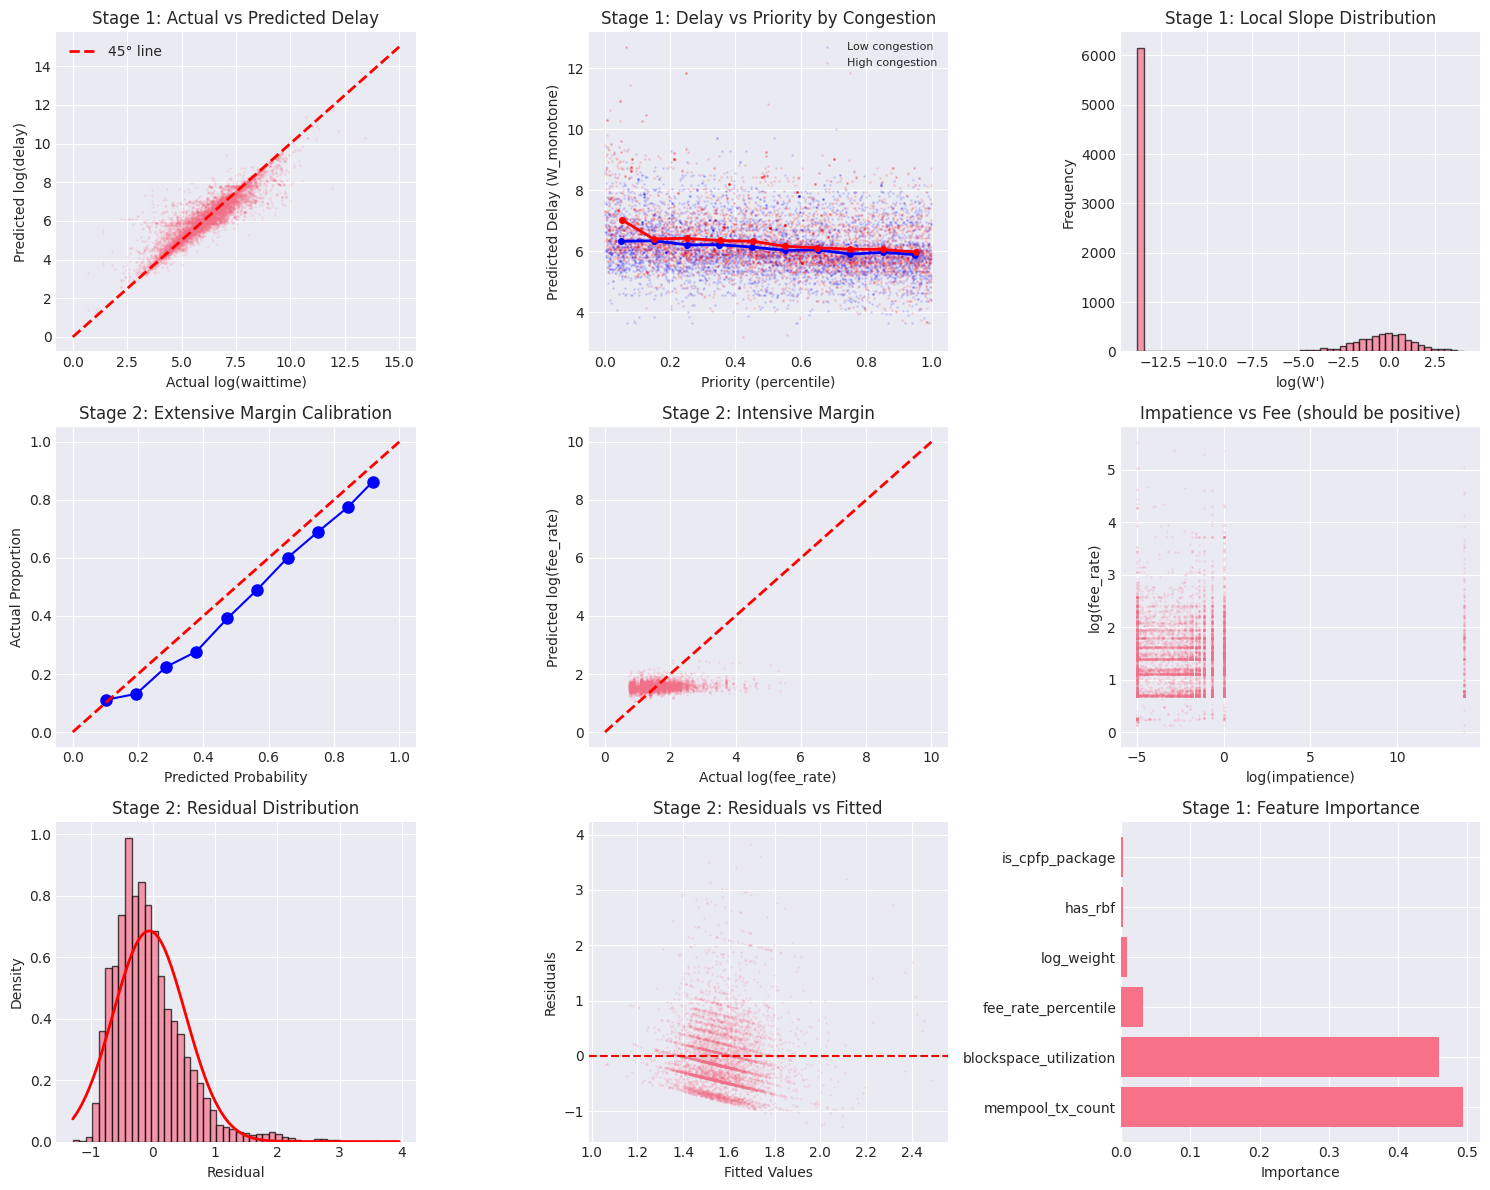


Diagnostic plot saved to: /home/kristian/notebooks/plots/fee_estimation_diagnostics.png


In [84]:
# =============================================================================
# Section 7.2: Diagnostic Visualizations
# =============================================================================

def plot_diagnostics(df: pd.DataFrame, stage1: DelayTechnologyEstimator, 
                    stage2: HurdleFeeModel, predictions: pd.DataFrame) -> plt.Figure:
    """
    Create a 3x3 diagnostic figure.
    
    Args:
        df: Prepared DataFrame
        stage1: Fitted Stage 1 model
        stage2: Fitted Stage 2 model
        predictions: Predictions DataFrame
        
    Returns:
        matplotlib Figure
    """
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    
    # Sample for visualization (to speed up plotting)
    sample_size = min(10000, len(predictions))
    sample = predictions.sample(sample_size, random_state=42)
    df_sample = df.loc[sample.index] if len(df) > sample_size else df
    
    # Row 1: Stage 1 Diagnostics
    # 1.1 Actual vs Predicted Delay
    ax = axes[0, 0]
    valid_mask = df_sample['W_hat'].notna() & df_sample['log_waittime'].notna()
    if valid_mask.sum() > 0:
        ax.scatter(df_sample.loc[valid_mask, 'log_waittime'], 
                  df_sample.loc[valid_mask, 'W_hat'], alpha=0.1, s=1)
        ax.plot([0, 15], [0, 15], 'r--', lw=2, label='45° line')
        ax.set_xlabel('Actual log(waittime)')
        ax.set_ylabel('Predicted log(delay)')
        ax.set_title('Stage 1: Actual vs Predicted Delay')
        ax.legend()
    
    # 1.2 Delay vs Priority BY CONGESTION LEVEL (should be decreasing, especially in high congestion)
    ax = axes[0, 1]
    # Use W_monotone if available, otherwise W_hat
    delay_col = 'W_monotone' if 'W_monotone' in df_sample.columns else 'W_hat'
    valid_mask = df_sample[delay_col].notna() & df_sample['fee_rate_percentile'].notna() & df_sample['mempool_tx_count'].notna()
    if valid_mask.sum() > 0:
        df_plot = df_sample[valid_mask].copy()
        # Split by congestion (mempool size)
        congestion_median = df_plot['mempool_tx_count'].median()
        high_cong = df_plot['mempool_tx_count'] > congestion_median
        low_cong = ~high_cong
        
        # Plot both groups
        ax.scatter(df_plot.loc[low_cong, 'fee_rate_percentile'], 
                  df_plot.loc[low_cong, delay_col], alpha=0.1, s=1, c='blue', label='Low congestion')
        ax.scatter(df_plot.loc[high_cong, 'fee_rate_percentile'], 
                  df_plot.loc[high_cong, delay_col], alpha=0.1, s=1, c='red', label='High congestion')
        
        # Add trend lines
        for mask, color, label in [(low_cong, 'blue', 'Low'), (high_cong, 'red', 'High')]:
            if mask.sum() > 100:
                bins = pd.cut(df_plot.loc[mask, 'fee_rate_percentile'], bins=10, labels=False)
                bin_means = df_plot.loc[mask].groupby(bins)[delay_col].mean()
                bin_centers = df_plot.loc[mask].groupby(bins)['fee_rate_percentile'].mean()
                ax.plot(bin_centers, bin_means, color=color, linewidth=2, marker='o', markersize=4)
        
        ax.set_xlabel('Priority (percentile)')
        ax.set_ylabel(f'Predicted Delay ({delay_col})')
        ax.set_title('Stage 1: Delay vs Priority by Congestion')
        ax.legend(loc='upper right', fontsize=8)
    
    # 1.3 Local Slope Distribution
    ax = axes[0, 2]
    valid_mask = df_sample['Wprime_hat'].notna()
    if valid_mask.sum() > 0:
        ax.hist(np.log(df_sample.loc[valid_mask, 'Wprime_hat'].clip(lower=1e-10)), 
               bins=50, edgecolor='black', alpha=0.7)
        ax.set_xlabel('log(W\')')
        ax.set_ylabel('Frequency')
        ax.set_title('Stage 1: Local Slope Distribution')
    
    # Row 2: Stage 2 Diagnostics
    # 2.1 Calibration Plot (Extensive Margin)
    ax = axes[1, 0]
    if 'P_fee_gt_eps' in sample.columns:
        # Create bins for calibration
        sample['prob_bin'] = pd.cut(sample['P_fee_gt_eps'], bins=10)
        actual = (sample['actual_fee_rate'] > stage2.config.fee_threshold_sat_vb).astype(int)
        calib = sample.groupby('prob_bin').agg({
            'P_fee_gt_eps': 'mean',
            'actual_fee_rate': lambda x: (x > stage2.config.fee_threshold_sat_vb).mean()
        })
        if len(calib) > 0:
            ax.plot(calib['P_fee_gt_eps'], calib['actual_fee_rate'], 'bo-', markersize=8)
            ax.plot([0, 1], [0, 1], 'r--', lw=2)
            ax.set_xlabel('Predicted Probability')
            ax.set_ylabel('Actual Proportion')
            ax.set_title('Stage 2: Extensive Margin Calibration')
    
    # 2.2 Predicted vs Actual (Intensive Margin)
    ax = axes[1, 1]
    payers = sample[sample['actual_fee_rate'] > stage2.config.fee_threshold_sat_vb]
    if len(payers) > 0:
        ax.scatter(np.log(payers['actual_fee_rate']), 
                  payers['E_log_fee_conditional'], alpha=0.1, s=1)
        ax.plot([0, 10], [0, 10], 'r--', lw=2)
        ax.set_xlabel('Actual log(fee_rate)')
        ax.set_ylabel('Predicted log(fee_rate)')
        ax.set_title('Stage 2: Intensive Margin')
    
    # 2.3 Impatience Effect
    ax = axes[1, 2]
    valid_mask = df_sample['log_impatience'].notna() & df_sample['log_fee_rate'].notna()
    if valid_mask.sum() > 0:
        ax.scatter(df_sample.loc[valid_mask, 'log_impatience'], 
                  df_sample.loc[valid_mask, 'log_fee_rate'], alpha=0.1, s=1)
        ax.set_xlabel('log(impatience)')
        ax.set_ylabel('log(fee_rate)')
        ax.set_title('Impatience vs Fee (should be positive)')
    
    # Row 3: Residual Diagnostics
    # 3.1 Residual Distribution
    ax = axes[2, 0]
    payers = sample[sample['actual_fee_rate'] > stage2.config.fee_threshold_sat_vb]
    if len(payers) > 0:
        residuals = np.log(payers['actual_fee_rate']) - payers['E_log_fee_conditional']
        ax.hist(residuals, bins=50, edgecolor='black', alpha=0.7, density=True)
        # Add normal overlay
        x = np.linspace(residuals.min(), residuals.max(), 100)
        ax.plot(x, stats.norm.pdf(x, residuals.mean(), residuals.std()), 'r-', lw=2)
        ax.set_xlabel('Residual')
        ax.set_ylabel('Density')
        ax.set_title('Stage 2: Residual Distribution')
    
    # 3.2 Residuals vs Fitted
    ax = axes[2, 1]
    if len(payers) > 0:
        residuals = np.log(payers['actual_fee_rate']) - payers['E_log_fee_conditional']
        ax.scatter(payers['E_log_fee_conditional'], residuals, alpha=0.1, s=1)
        ax.axhline(y=0, color='r', linestyle='--')
        ax.set_xlabel('Fitted Values')
        ax.set_ylabel('Residuals')
        ax.set_title('Stage 2: Residuals vs Fitted')
    
    # 3.3 Feature Importance (from Random Forest)
    ax = axes[2, 2]
    if stage1.model is not None:
        importances = stage1.model.feature_importances_
        feature_names = stage1.FEATURES
        idx = np.argsort(importances)[::-1]
        ax.barh(range(len(importances)), importances[idx])
        ax.set_yticks(range(len(importances)))
        ax.set_yticklabels([stage1.FEATURES[i] for i in idx])
        ax.set_xlabel('Importance')
        ax.set_title('Stage 1: Feature Importance')
    
    plt.tight_layout()
    return fig

# Generate diagnostics
fig = plot_diagnostics(df, stage1, stage2, predictions)
plt.savefig('/home/kristian/notebooks/plots/fee_estimation_diagnostics.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nDiagnostic plot saved to: /home/kristian/notebooks/plots/fee_estimation_diagnostics.png")

---
## Section 8: Testing and Validation

This section includes:
- Synthetic data generator for pipeline validation
- End-to-end tests
- Model export/save functions

In [85]:
# =============================================================================
# Section 8.1: Synthetic Data Generator
# =============================================================================

def create_synthetic_data(n_transactions: int = 10000, n_epochs: int = 100,
                         seed: int = 42) -> pd.DataFrame:
    """
    Generate realistic synthetic transaction data for pipeline validation.
    
    The data generating process follows the structural model:
    - Priority determines delay (higher priority = lower delay)
    - Fees reflect impatience and delay gradient
    - RBF/CPFP flags affect fees
    
    Args:
        n_transactions: Number of transactions
        n_epochs: Number of epochs
        seed: Random seed
        
    Returns:
        DataFrame with synthetic transaction data
    """
    np.random.seed(seed)
    
    print(f"Generating synthetic data...")
    print(f"  Transactions: {n_transactions:,}")
    print(f"  Epochs: {n_epochs}")
    
    # Generate basic features
    df = pd.DataFrame({
        'tx_id': [f'tx_{i:08d}' for i in range(n_transactions)],
        'conf_block_hash': [f'block_{i % (n_epochs * 2):04d}' for i in range(n_transactions)],
    })
    
    # Assign to epochs
    df['epoch_id'] = np.random.randint(0, n_epochs, n_transactions)
    
    # Generate timestamps (30-min epochs)
    base_time = pd.Timestamp('2025-08-01')
    df['found_at'] = base_time + pd.to_timedelta(
        df['epoch_id'] * 30 + np.random.uniform(0, 30, n_transactions), unit='min'
    )
    df['mined_at'] = df['found_at'] + pd.to_timedelta(
        np.random.exponential(10, n_transactions), unit='min'
    )
    
    # Transaction characteristics
    df['weight'] = np.random.lognormal(6, 0.5, n_transactions).astype(int).clip(250, 100000)
    df['size'] = (df['weight'] / 4).astype(int)
    df['total_output_amount'] = np.random.lognormal(15, 2, n_transactions).astype(int)
    
    # Congestion state (varies by epoch)
    epoch_congestion = np.random.lognormal(10, 0.5, n_epochs)
    df['mempool_tx_count'] = epoch_congestion[df['epoch_id']]
    df['mempool_size'] = df['mempool_tx_count'] * 500
    
    # Impatience (min_respend_blocks)
    # Lower values = more impatient
    df['min_respend_blocks'] = np.random.choice(
        [-1, 0, 1, 2, 3, 5, 10, 50, 100, 144],
        n_transactions,
        p=[0.1, 0.15, 0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05]
    )
    
    # RBF/CPFP
    df['rbf_fee_total'] = np.where(np.random.random(n_transactions) < 0.05,
                                   np.random.lognormal(6, 1, n_transactions), np.nan)
    df['child_txid'] = np.where(np.random.random(n_transactions) < 0.25,
                                [f'child_{i}' for i in range(n_transactions)], None)
    
    # Generate fees based on structural model
    # fee = base + impatience_effect + congestion_effect + rbf_effect + noise
    base_fee = 1.0
    
    # Impatience effect (lower min_respend = higher fee)
    impatience = 1 / (df['min_respend_blocks'].clip(lower=1) + 1)
    impatience_effect = 2 * np.log1p(impatience * 10)
    
    # Congestion effect
    congestion_effect = 0.5 * np.log1p(df['mempool_tx_count'] / 10000)
    
    # RBF effect
    rbf_effect = np.where(df['rbf_fee_total'].notna(), 0.5, 0)
    
    # Weight effect
    weight_effect = 0.1 * np.log1p(df['weight'] / 1000)
    
    # Noise
    noise = np.random.normal(0, 0.5, n_transactions)
    
    # Combined fee rate (sat/vB)
    df['fee_rate'] = np.exp(
        np.log(base_fee) + impatience_effect + congestion_effect + 
        rbf_effect + weight_effect + noise
    ).clip(0.1, 1000)
    
    df['absolute_fee'] = (df['fee_rate'] * df['weight'] / 4).astype(int)
    
    # Wait time (higher fee = lower wait)
    base_wait = 600  # 10 minutes
    df['waittime'] = (
        base_wait * np.exp(-0.5 * np.log(df['fee_rate'])) + 
        np.random.exponential(60, n_transactions)
    ).clip(1, 86400).astype(int)
    
    print(f"✓ Synthetic data generated")
    print(f"  Fee rate range: [{df['fee_rate'].min():.2f}, {df['fee_rate'].max():.2f}]")
    print(f"  Wait time range: [{df['waittime'].min()}, {df['waittime'].max()}] seconds")
    
    return df

# Generate synthetic data
df_synthetic = create_synthetic_data(n_transactions=5000, n_epochs=50)

Generating synthetic data...
  Transactions: 5,000
  Epochs: 50
✓ Synthetic data generated
  Fee rate range: [0.48, 422.73]
  Wait time range: [32, 925] seconds


In [86]:
# =============================================================================
# Section 8.2: End-to-End Test on Synthetic Data
# =============================================================================

def run_pipeline_tests(df_test: pd.DataFrame, config: EstimationConfig) -> Dict[str, bool]:
    """
    Run end-to-end tests on the pipeline.
    
    Args:
        df_test: Test DataFrame
        config: EstimationConfig
        
    Returns:
        Dictionary of test results
    """
    results = {}
    
    print("\n" + "=" * 60)
    print("RUNNING PIPELINE TESTS")
    print("=" * 60)
    
    # Test 1: Feature Preparation
    print("\n[Test 1] Feature Preparation...")
    try:
        df_prep = prepare_features(df_test.copy(), config)
        assert 'epoch_id' in df_prep.columns
        assert 'fee_rate_percentile' in df_prep.columns
        assert 'impatience' in df_prep.columns
        assert df_prep['fee_rate_percentile'].min() > 0
        assert df_prep['fee_rate_percentile'].max() < 1
        results['feature_preparation'] = True
        print("  ✓ PASSED")
    except Exception as e:
        results['feature_preparation'] = False
        print(f"  ✗ FAILED: {e}")
        return results
    
    # Test 2: Stage 1 Fitting
    print("\n[Test 2] Stage 1 (Delay Technology)...")
    try:
        stage1_test = DelayTechnologyEstimator(config)
        stage1_test.fit(df_prep)
        assert stage1_test.is_fitted
        assert stage1_test.model is not None  # Single model (VCG-style)
        results['stage1_fit'] = True
        print("  ✓ PASSED")
    except Exception as e:
        results['stage1_fit'] = False
        print(f"  ✗ FAILED: {e}")
        return results
    
    # Test 3: Monotonicity Enforcement (per-observation isotonic)
    print("\n[Test 3] Monotonicity Enforcement (Isotonic Regression)...")
    try:
        W_hat = stage1_test.predict_W_hat(df_prep)
        W_monotone = stage1_test.predict_delay_monotone_per_obs(df_prep, W_hat, verbose=False)
        assert len(W_monotone) > 0
        assert not np.any(np.isnan(W_monotone))
        results['monotonicity'] = True
        print("  ✓ PASSED")
    except Exception as e:
        results['monotonicity'] = False
        print(f"  ✗ FAILED: {e}")
    
    # Test 4: Local Slope Computation (finite differences)
    print("\n[Test 4] Local Slope Computation (Finite Differences)...")
    try:
        Wprime_hat = stage1_test.compute_slope_finite_diff_per_obs(df_prep, W_monotone, delta=0.05, verbose=False)
        assert len(Wprime_hat) > 0
        assert np.all(Wprime_hat > 0)  # Slopes should be positive
        results['local_slopes'] = True
        print("  ✓ PASSED")
    except Exception as e:
        results['local_slopes'] = False
        print(f"  ✗ FAILED: {e}")
    
    # Add Stage 1 outputs to df
    df_prep['W_hat'] = np.nan
    df_prep['W_monotone'] = np.nan
    df_prep['Wprime_hat'] = np.nan
    df_prep.loc[stage1_test._valid_indices, 'W_hat'] = W_hat
    df_prep.loc[stage1_test._valid_indices, 'W_monotone'] = W_monotone
    df_prep.loc[stage1_test._valid_indices, 'Wprime_hat'] = Wprime_hat
    df_prep['log_Wprime'] = np.log(df_prep['Wprime_hat'].clip(lower=1e-6))
    
    # Test 5: I-Spline Transformer
    print("\n[Test 5] I-Spline Transformer...")
    try:
        x = np.linspace(0, 1, 100)
        ispline_test = ISplineTransformer(n_knots=4, degree=3)
        basis = ispline_test.fit_transform(x)
        
        # Check monotonicity
        for j in range(basis.shape[1]):
            diffs = np.diff(basis[:, j])
            assert np.all(diffs >= -1e-10), f"Basis {j} not monotone"
        
        results['ispline'] = True
        print("  ✓ PASSED")
    except Exception as e:
        results['ispline'] = False
        print(f"  ✗ FAILED: {e}")
    
    # Test 6: Stage 2 Fitting
    print("\n[Test 6] Stage 2 (Hurdle Model)...")
    try:
        stage2_test = HurdleFeeModel(config)
        stage2_test.fit(df_prep)
        assert stage2_test._is_fitted
        assert stage2_test.smearing_factor > 0
        results['stage2_fit'] = True
        print("  ✓ PASSED")
    except Exception as e:
        results['stage2_fit'] = False
        print(f"  ✗ FAILED: {e}")
        return results
    
    # Test 7: Predictions
    print("\n[Test 7] Predictions...")
    try:
        # Create estimator from fitted components
        estimator_test = BitcoinFeeEstimator(config)
        estimator_test.stage1 = stage1_test
        estimator_test.stage2 = stage2_test
        estimator_test.df_prepared = df_prep
        estimator_test._is_fitted = True
        
        predictions = estimator_test.predict()
        assert len(predictions) > 0
        assert 'P_fee_gt_eps' in predictions.columns
        assert predictions['P_fee_gt_eps'].min() >= 0
        assert predictions['P_fee_gt_eps'].max() <= 1
        results['predictions'] = True
        print("  ✓ PASSED")
    except Exception as e:
        results['predictions'] = False
        print(f"  ✗ FAILED: {e}")
    
    # Test 8: Clustered SEs
    print("\n[Test 8] Clustered Standard Errors...")
    try:
        se_summary = compute_intensive_margin_se(stage2_test, df_prep)
        assert len(se_summary) > 0
        assert np.all(se_summary['se_clustered'] > 0)
        results['clustered_se'] = True
        print("  ✓ PASSED")
    except Exception as e:
        results['clustered_se'] = False
        print(f"  ✗ FAILED: {e}")
    
    # Summary
    print("\n" + "=" * 60)
    print("TEST SUMMARY")
    print("=" * 60)
    passed = sum(results.values())
    total = len(results)
    print(f"\nPassed: {passed}/{total}")
    
    for test_name, passed in results.items():
        status = "✓" if passed else "✗"
        print(f"  {status} {test_name}")
    
    return results

# Run tests on synthetic data
test_config = EstimationConfig(
    block_limit=None,  # Not used for synthetic
    n_folds=3,  # Fewer folds for faster testing
    rf_n_estimators=50,  # Fewer trees for faster testing
    p_grid_size=21  # Smaller grid for faster testing
)

test_results = run_pipeline_tests(df_synthetic, test_config)


RUNNING PIPELINE TESTS

[Test 1] Feature Preparation...

FEATURE PREPARATION PIPELINE
Assigning epochs...
  Mode: Time-based epochs (30 min each)
✓ Created 50 time-based epochs

  Epoch Statistics:
    Total epochs: 50
    Transactions per Epoch:
      Min:    72
      25%:    93
      Median: 101
      Mean:   100
      75%:    107
      Max:    123
    ✓ No sparse epochs (all have >= 50 txs)
Computing tie-aware fee-rate percentiles...
✓ Percentiles computed: range [0.0041, 0.9959]
  Mean: 0.5000, Median: 0.5000
Computing impatience proxy...
✓ Impatience proxy computed
  Valid respend data: 4,517 (90.3%)
  Mean ι: 140000.301017
  Median ι: 0.333333
Computing blockspace utilization...
✓ Blockspace utilization computed
  Mean: 0.003
  Range: [0.000, 0.007]
Creating derived features...
✓ Derived features created
  RBF transactions: 264 (5.28%)
  CPFP packages: 1,220 (24.40%)

FEATURE PREPARATION COMPLETE

Features prepared:
  epoch_id: 5,000 non-null
  fee_rate_percentile: 5,000 non-nul

In [87]:
# =============================================================================
# Section 8.3: Save/Export Functions
# =============================================================================

def export_results(estimator: BitcoinFeeEstimator, predictions: pd.DataFrame,
                  output_dir: str = '/home/kristian/notebooks/model_outputs') -> Dict[str, str]:
    """
    Export fitted model and results.
    
    Args:
        estimator: Fitted BitcoinFeeEstimator
        predictions: Predictions DataFrame
        output_dir: Output directory
        
    Returns:
        Dictionary of output file paths
    """
    import os
    from datetime import datetime
    
    os.makedirs(output_dir, exist_ok=True)
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    paths = {}
    
    # Save model
    model_path = f'{output_dir}/fee_estimator_{timestamp}.pkl'
    estimator.save(model_path)
    paths['model'] = model_path
    
    # Save predictions
    pred_path = f'{output_dir}/predictions_{timestamp}.csv'
    predictions.to_csv(pred_path, index=False)
    paths['predictions'] = pred_path
    print(f"Predictions saved to: {pred_path}")
    
    # Save coefficient summary
    coef_path = f'{output_dir}/coefficients_{timestamp}.csv'
    coef_summary = estimator.stage2.get_coefficient_summary()
    coef_summary.to_csv(coef_path, index=False)
    paths['coefficients'] = coef_path
    print(f"Coefficients saved to: {coef_path}")
    
    # Save summary
    summary_path = f'{output_dir}/summary_{timestamp}.txt'
    with open(summary_path, 'w') as f:
        f.write("Bitcoin Fee Estimation Pipeline - Summary\n")
        f.write("=" * 50 + "\n\n")
        
        summary = estimator.summary()
        for section, values in summary.items():
            f.write(f"{section}:\n")
            if isinstance(values, dict):
                for k, v in values.items():
                    f.write(f"  {k}: {v}\n")
            f.write("\n")
    
    paths['summary'] = summary_path
    print(f"Summary saved to: {summary_path}")
    
    return paths

# Export results (uncomment to run)
# output_paths = export_results(estimator, predictions)
print("\nTo save the model, run: output_paths = export_results(estimator, predictions)")


To save the model, run: output_paths = export_results(estimator, predictions)


---
## Summary

This notebook implements the complete two-stage fee estimation pipeline:

### Stage 1: Delay Technology Estimation
- **Model**: Random Forest with epoch-level cross-fitting
- **Output**: Predicted delay W(p, s) and local slope W'(p, s)
- **Key Feature**: Monotonicity enforcement via IsotonicRegression

### Stage 2: Hurdle Fee Model  
- **Extensive Margin**: Constrained logistic regression for P(fee > ε)
- **Intensive Margin**: Constrained OLS for E[log(fee) | fee > ε]
- **Key Feature**: I-Spline basis for monotone impatience effect

### Key Results
- Priority enters only through the delay gradient (VCG-consistent)
- Clustered standard errors account for within-epoch correlation
- Smearing correction for level predictions

### Usage
```python
# Full pipeline
estimator = BitcoinFeeEstimator(config)
estimator.fit(df)
predictions = estimator.predict()

# Save model
estimator.save('model.pkl')

# Load model
estimator = BitcoinFeeEstimator.load('model.pkl')
```